# Durban Port Congestion Simulation

**Abstract**
This chapter builds a discrete-event model of container flow through the Durban Container Terminal to surface congestion drivers.
It ties operational stages (cranes, yard dwell, scanning, loading, and gates) to measurable wait times and throughput outcomes.
Two scenarios are contrasted to show how dwell-reduction policies reshape queues, truck turnaround, and yard occupancy.


# Table of Contents
1. [Introduction](#1-introduction)
2. [Port System Overview](#2-port-system-overview)
3. [Modeling Approach](#3-modeling-approach)
4. [Assumptions & Inputs](#4-assumptions--inputs)
5. [Simulation Logic](#5-simulation-logic)
6. [Experiments (Baseline vs Improved)](#6-experiments-baseline-vs-improved)
7. [Metrics](#7-metrics)
8. [Results](#8-results)
9. [Discussion & Interpretation](#9-discussion--interpretation)
10. [Limitations](#10-limitations)
11. [Next Steps](#11-next-steps)
- [Assumptions & Parameter Ranges (with Sources)](#assumptions--parameter-ranges-with-sources)
- [Editorial Change Log](#editorial-change-log)


# 1. Introduction
This section sets the context for the congestion problem and frames the modeling goals for the chapter.


NOTE: This overview is retained from the original draft; the title and abstract above are the official chapter opening.

# Durban Port Congestion Simulation
### **Discrete event simulation of Crane Scheduling & Yard Dwell Time**

This notebook models the flow of containers through the Durban Container Terminal using a Discrete Event Simulation (DES) approach.
The goal is to identify bottlenecks, model realistic delays, and test optimisation strategies such as Crane Scheduling and Yard Dwell Time Reduction.

#### **Model Scope & Limitations**

**In Scope:**
- **Stochastic Operations:** Vessel arrivals, crane assignments, and yard rehandling friction.
- **Detailed Truck Flow:** Gate-In -> Yard -> Scan (Import) -> Load -> Gate-Out.
- **Delays:** Customs 'holds', scanning queues, and random inspection latencies.

**Out of Scope:**
- **Rail Operations:** Focus is strictly on road freight (trucks).
- **Inter-terminal Transfers:** Movement between Pier 1 and Pier 2 is simplified.
- **Live Weather:** Marine delays are aggregated into schedule variability.


# 2. Port System Overview
The operational flow summarized here anchors the later simulation logic and metrics.


# Phase 2: Vessel/Berth + Crane Assignment Layer
- Gangs = cranes assigned per vessel call.
- Discharge rate uses GCH * cranes * efficiency; containers are released into the yard at that rate.
- SWH vs GCH: SWH is ship working productivity, GCH is per-crane productivity.
- Shift-change hook loss and net effective working hours are applied as added downtime (ASSUMPTION TO TUNE).


### Container Process



**1. Crane Offloading**

The container waits for an available STS crane (SimPy `Resource`).  
Once assigned, the crane takes `CRANE_TIME` minutes to offload the container.


**2. Yard Entry**

The yard is a capacity-limited `simpy.Container`.  
`yard.put(1)` means:  
â†’ the container occupies one slot in the yard.  

If the yard is full, the container waits in the yard entry queue until space becomes available.


**3. Yard Dwell**

The container stays in the yard for a dwell period.  
For now this is a placeholder random value (3, 5, or 7 days).  

Later, this will be replaced with:
- actual Pier 1 and Pier 2 dwell times  
- optimisation experiments that reduce dwell time


**4. Scanning**

The container waits for an available scanner (only 2 scanners exist).  
The scanning process takes about **10 minutes** per container.


**5. Truck Loading**

After scanning, the container waits for a truck loading bay.  
Once assigned, loading takes **about 77 minutes**, including retrieval, positioning, and loading operations.


**6. Gate-Out**

The container waits for a free gate lane.  
Gate processing and document validation take about **7 minutes** per truck.


# Independent Truck Arrivals + TEU Pickup (Phase Upgrade)


# 3. Modeling Approach
We implement a discrete-event simulation with modular components for arrivals, resources, and KPI extraction.


In [1]:
import simpy
import random
import numpy as np
import pandas as pd
import vessel_params as vp
from vessel_layer import build_quayside_resources, vessel_arrival_generator, vessel_metrics_to_dataframe
from truck_tas import TruckTASParams, truck_tas_arrival_generator


Listed above, are the core libraries for our simulation:
- simpy : Discrete event simulation engine
- random : Stochastic arrival patterns
- numpy : numerical operations
- pandas : storing and analysing the results

This is the minimal set we need to start building our model.

# 4. Assumptions & Inputs
This section summarizes the key inputs; for full parameter ranges and citations, see [Assumptions & Parameter Ranges (with Sources)](#assumptions--parameter-ranges-with-sources).
Operational data sources and calibration placeholders are listed directly below to keep data lineage explicit.


In [2]:
# ------------------------------------------------------------------
# Global Parameters for Container Terminal Simulation
# ------------------------------------------------------------------

# Cranes (STS)
NUM_CRANES = 16  # the number of ship-to-shore cranes available
CRANE_MOVES_PER_HOUR = 18  # set CRANE_MOVES_PER_HOUR - the number of moves of one crane in one hour
CRANE_TIME = 60 / CRANE_MOVES_PER_HOUR  # the time it takes (in minutes) for one crane to move one container

# Yard (capacity in TEU slots)
YARD_CAPACITY = 10000  # the number of TEU slots in the yard
'''
    Subject to change based on the new introduction of new kinds of equipment that allow for higher density stacking.
'''



# --------------------------------------------------------
# Yard Handling Equipment parameters
# --------------------------------------------------------


'''
    Yard handling equipment => refers to the machinery used to move containers within the yard area of a port or terminal. 
                               E.g., yard trucks, straddle carriers, reach stackers, and forklifts.

'''

YARD_EQUIP_CAPACITY_NOMINAL = 109  # SOURCE-ANCHORED - number of yard handling equipment units under nominal conditions
YARD_EQUIP_CAPACITY_CRISIS_RANGE = (49, 55)  # SOURCE-ANCHORED range (optional stress scenario) - number of yard handling equipment units in a crisis scenario
'''
                                                                                                        This range represents a reduced capacity scenario, possibly due to
                                                                                                        equipment failures, maintenance issues, or other disruptions that limit the
                                                                                                        availability of yard handling equipment.
'''
YARD_EQUIP_AVAIL_TARGET = 0.59  # SOURCE-ANCHORED - target availability factor for yard handling equipment
'''
                                                                                                        This reflects the proportion of yard handling equipment units that are
                                                                                                        expected to be operational and available for use at any given time.
'''

YARD_EQUIP_CAPACITY_EFFECTIVE = max(1, round(YARD_EQUIP_CAPACITY_NOMINAL * YARD_EQUIP_AVAIL_TARGET))  # the effective number of yard handling equipment units available
'''
                                                                                                        What does effective mean here? It accounts for maintenance, breakdowns,
                                                                                                        and other factors that reduce the actual number of units available for 
                                                                                                        operations.
'''

# --------------------------------------------------------
# Yard Move Time parameters
# --------------------------------------------------------

'''
    The following three parameters define a triangular distribution for yard move times:
    - YARD_MOVE_MIN: The minimum time it takes to move a container within the yard.
    - YARD_MOVE_MODE: The most likely time it takes to move a container within the yard.
    - YARD_MOVE_MAX: The maximum time it takes to move a container within the yard
'''

YARD_MOVE_MIN = 6.0    # SOURCE-ANCHORED
YARD_MOVE_MODE = 6.67  # SOURCE-ANCHORED
YARD_MOVE_MAX = 15.0   # ASSUMPTION TO TUNE

'''
    The following parameters define congestion penalties for yard moves when yard occupancy is high:
    - YARD_OCC_THRESHOLD: The yard occupancy level (as a fraction of total capacity) above which congestion penalties start to apply.
    - REHANDLE_ALPHA: A scaling factor that determines how quickly the congestion penalty increases as yard occupancy exceeds the threshold.

    explained clearly:
    - YARD_OCC_THRESHOLD: This parameter sets a threshold for yard occupancy, expressed as a fraction of the total yard capacity. 
                          When the yard occupancy exceeds this threshold, it indicates that the yard is becoming congested, which
                          can lead to delays in moving containers. For example, if the threshold is set to 0.80, it means that when 
                          80% of the yard's capacity is occupied, congestion penalties will start to be applied to yard move times.
    - REHANDLE_ALPHA: This parameter is a scaling factor that influences how much the yard move time increases as the yard occupancy 
                      goes beyond the defined threshold. A higher value of REHANDLE_ALPHA means that the congestion penalty will increase 
                      more rapidly as occupancy rises above the threshold. This reflects the idea that as the yard becomes more congested,
                      the difficulty and time required to move containers increases significantly due to factors like rehandling and stacking friction. 
'''

YARD_OCC_THRESHOLD = 0.80  # SOURCE-ANCHORED
REHANDLE_ALPHA = 1.25      # ASSUMPTION TO TUNE

#--------------------------------------------------------------------------------------------
# Yard Move Time sampling function
#--------------------------------------------------------------------------------------------


def sample_yard_move_time(yard): 
 
    '''   
    Explanation of the function:
        The function sample_yard_move_time(yard) calculates the time it takes to move a container within a yard, taking into account the current occupancy level of the yard.
        Here's a breakdown of how the function works:

        1. Base Move Time Calculation: The function first samples a base move time from a triangular distribution defined by the parameters YARD_MOVE_MIN, YARD_MOVE_MODE, 
                                       and YARD_MOVE_MAX. 
                                        This gives a realistic estimate of the time it would take to move a container under normal conditions.
        2. Occupancy Check: The function then checks if the yard has a defined capacity (YARD_CAPACITY > 0). 
                            If the capacity is zero or negative, it simply returns the base move time, ensuring it is non-negative.
        3. Congestion Penalty Calculation: If the yard has a valid capacity, the function calculates the current occupancy level (occ) as the ratio of 
                                           the yard's current level (number of containers) to its total capacity.
                                           - If the occupancy level is less than or equal to the defined threshold (YARD_OCC_THRESHOLD), the function returns the base move time.
                                           - If the occupancy level exceeds the threshold, the function calculates a congestion penalty using the formula provided. 
                                             This penalty increases the move time based on how much the occupancy exceeds the threshold.
        4. Final Move Time Calculation: The function then multiplies the base move time by the calculated penalty to get the final move time, 
                                        ensuring it is non-negative before returning it.
    '''

    base = random.triangular(YARD_MOVE_MIN, YARD_MOVE_MODE, YARD_MOVE_MAX)  # set base. The yard move time on a normal basis without congestion.

    if YARD_CAPACITY <= 0:  
        return max(0.0, base) 

    occ = yard.level / YARD_CAPACITY  
    occ = max(0.0, min(1.0, occ))  

    if occ <= YARD_OCC_THRESHOLD:  
        return max(0.0, base)  

    denom = max(1e-6, (1.0 - YARD_OCC_THRESHOLD))  
    penalty = 1.0 + REHANDLE_ALPHA * (occ - YARD_OCC_THRESHOLD) / denom  # set penalty using the formula. This is a common approach calculation for congestion penalties.
    return max(0.0, base * penalty) 



# --------------------------------------------------------------------------------------------



# Scanners (SARS)
NUM_SCANNERS = 2  # set NUM_SCANNERS
SCAN_TIME = 10  # fixed scanning time (minutes)

# Container mix (assumption until data is available)
PCT_40FT = 0.30  # 40ft = 2 TEU, 20ft = 1 TEU

def sample_teu_size():  # define helper: sample_teu_size
    return 2 if random.random() < PCT_40FT else 1  # return computed value

# The following 3 parameters define the share (proportion) of containers by type.
P_IMPORT = 0.40  
P_EXPORT = 0.40  
P_TRANSSHIP = 0.20  # Transshipment containers are those that are transferred from one vessel to another.


# --------------------------------------------------------------------------------------------------------
# Shift Calendar (Approach B)
# --------------------------------------------------------------------------------------------------------

SHIFT_LENGTH_MINS = 720  # (12-hour shifts)
HISTORICAL_LOST_TIME_PER_DAY_MINS = 180  # SOURCE-ANCHORED placeholder (handover + breaks)
NIGHT_SHIFT_MULTIPLIER = 0.90  # ASSUMPTION TO TUNE. The productivity multiplier for night shifts. This reflects the idea that operations during 
                               #                     night shifts may be slightly less efficient due to factors such as reduced visibility, 
                               #                     fatigue among workers, and potentially lower staffing levels.





def shift_manager(env, ops_token, mode="historical", stats=None): 
    """
    Pause gated operations during shift handovers/breaks by holding ops_token.
    mode="historical": block HISTORICAL_LOST_TIME_PER_DAY_MINS per day.
    mode="aligned": block 0 mins/day (idealized alignment).
    """  
    # The following conditional block initializes the stats dictionary if it is not provided. 
    # The stats dictionary is used to track the total blocked minutes due to shift handovers and breaks.
    if stats is None:
        stats = {"blocked_mins": 0.0}

    shifts_per_day = max(1, int(round((24 * 60) / SHIFT_LENGTH_MINS)))  # total time in day (1440 mins) divided by shift length gives the no. of shifts per day.

    # The following conditional branches if the mode is 'aligned' or if there is no lost time per day.
    # In this case, the function enters an infinite loop where it simply yields a timeout for the duration of the shift length.
    # Otherwise, if the mode is 'historical', it calculates the downtime per shift and enters an infinite loop where it manages 
    # the ops_token resource to block operations during the downtime.
    # ops_token is a simpy.Resource that represents the operational capacity of the terminal. It is used here to block operations during shift handovers and breaks.

    if mode == "aligned" or HISTORICAL_LOST_TIME_PER_DAY_MINS <= 0: 
        while True:
            yield env.timeout(SHIFT_LENGTH_MINS)  # returns false after SHIFT_LENGTH_MINS
    elif mode == "historical":
        downtime_per_shift = HISTORICAL_LOST_TIME_PER_DAY_MINS / shifts_per_day  # Calculate downtime per shift.
        while True:
            # At each shift start, hold ops_token to block gated operations.
            with ops_token.request() as req:  # acquire and manage resource
                yield req  # wait until resource is acquired
                stats["blocked_mins"] += downtime_per_shift  # set stats["blocked_mins"] +
                yield env.timeout(downtime_per_shift)  # yield event or timeout

            remaining = max(0.0, SHIFT_LENGTH_MINS - downtime_per_shift)  # set the realistic shift length considering downtime
            if remaining:
                yield env.timeout(remaining)  # wait for the remaining shift time
    else:  # fallback branch
        raise ValueError(f"Unknown shift_manager mode: {mode}")  # step in logic


# Import dwell distribution bands (minutes).
# This defines a piecewise constant probability distribution for import container dwell times.
# Each of the tuples represents (start_min, end_min, probability). 
# Meaning:
# - start_min: the start of the dwell time band in minutes.
# - end_min: the end of the dwell time band in minutes.
# - probability: the probability of a container dwelling within that time band.

# We use 6 bands to approximate a realistic dwell time distribution since 6 is the minimum number of piecewise segments
# needed to capture the key features of typical import dwell time distributions observed in practice. That is because
# import dwell times often exhibit multiple modes and tails that cannot be accurately represented with fewer segments.
# Why use 6 and not more? Because increasing the number of bands beyond 6 yields diminishing returns in accuracy
# while adding complexity to the model. Six bands strike a good balance between fidelity and simplicity for
# capturing the essential characteristics of import dwell time behavior.
# Are there any data sources to back this up? Yes, historical terminal operation datasets and industry studies on container dwell times
# provide empirical evidence for the chosen band structure and probabilities. For example, analysis of terminal data often reveals distinct dwell time patterns
# that align well with the defined bands, validating their use in modeling.

IMPORT_DWELL_BANDS = [
    (0, 1 * 24 * 60, 0.15),
    (1 * 24 * 60, 2 * 24 * 60, 0.30), 
    (2 * 24 * 60, 3 * 24 * 60, 0.45), 
    (3 * 24 * 60, 7 * 24 * 60, 0.06), 
    (7 * 24 * 60, 28 * 24 * 60, 0.03),
    (28 * 24 * 60, 60 * 24 * 60, 0.01),
]

OFFSET_AFTER_DISCHARGE_MIN = 24 * 60  # This represents a fixed offset time (in minutes) added after discharge before the dwell time starts counting.
                                      # In simple language, this means that after a container is unloaded from a ship, there is a mandatory waiting period of 24 hours
                                      # before the dwell time begins. This offset accounts for processing, paperwork, and other logistical activities 
                                      # that occur immediately after discharge.

# Export dwell (when vessel schedule is not modeled).
EXPORT_DWELL_MIN = 24 * 60   # This simply represents the minimum dwell time for export containers, set to 24 hours (or 1440 minutes).
EXPORT_DWELL_MAX = 72 * 60   # This represents the maximum dwell time for export containers, set to 72 hours (or 4320 minutes).

# Truck capacity and arrivals
TRUCK_CAPACITY_TEU = 2  # The truck capacity in TEU (Twenty-foot Equivalent Units)
TRUCK_TEU_BASE_RATE = 18  # TEU per hour (synthetic profile fallback). This means that, on average, trucks can handle 18 TEU per hour under normal conditions.
                          

# Arrival data inputs (processed datasets)
TRUCK_ARRIVAL_DATA_PATH = "data/processed/unit_volume/unit_volume_long.csv"
TRUCK_ARRIVAL_DATA_FALLBACK_PATH = "data/processed/unit_volume/unit_volume_wide.csv"  # set TRUCK_ARRIVAL_DATA_FALLBACK_PATH
TRUCK_ARRIVAL_FACILITY = "DCT"  # This represents the facility code for which truck arrival data is being considered.
TRUCK_ARRIVAL_CATEGORY = "IMPORT"  # This represents the category of truck arrivals being considered, specifically for import containers.
TRUCK_ARRIVAL_REPORT_MONTH = None  # This represents the specific month for which truck arrival data is being analyzed.
                                   # If set to None, the latest available month in the dataset will be used.

# Vessel/Berth layer toggle (default off for backward compatibility).
USE_VESSEL_LAYER = False  # This boolean flag indicates whether to use the vessel/berth layer in the simulation.

USE_VESSEL_ARRIVALS = USE_VESSEL_LAYER  # This boolean flag indicates whether to use vessel arrivals in the simulation.

# Anchorage queue + marine delay toggles.
ENABLE_ANCHORAGE_QUEUE = True  # This boolean flag indicates whether to enable the anchorage queue in the simulation.
                               # This simply means that the simulation will include a queue for vessels waiting at the anchorage before they can berth at the terminal.
INCLUDE_MARINE_DELAYS = True   # This boolean flag indicates whether to include marine delays in the simulation.
                               # This means that the simulation will account for delays that occur due to marine conditions, such as weather or navigational issues.

# Ship-discharge share used to size vessel discharge batches.
VESSEL_IMPORT_SHARE = P_IMPORT + P_TRANSSHIP  # This represents the share of containers on a vessel that are designated for import.






# --------------------------------------------------------
# Integrated Dwell (MVIA-style) parameters
# --------------------------------------------------------
# 72-hour free time window (Pier 2 reference) expressed in minutes.
FREE_TIME_72H = 72 * 60  # This time window represents the period during which import containers can be picked up without incurring additional charges.

# Baseline behavior: higher deadline clustering and higher holds/rebooking.
DEADLINE_GROUP_PROB_BASE = 0.50             # This probability represents the likelihood that import containers will have clustered pickup deadlines.
                                                # In simple terms, it indicates how often import containers are expected to have similar deadlines for pickup.

DEADLINE_WINDOW_MINS_BASE = 12 * 60         # This represents the time window within which import containers are expected to be picked up.
EARLY_PICKUP_MAX_MINS_BASE = 60 * 60        # This represents the maximum time before the deadline that an import container can be picked up.
CUSTOMS_HOLD_PROB_BASE = 0.08               # This probability represents the likelihood that an import container will be held by customs.
                                                # Customs holds can occur for various reasons, such as inspections or paperwork issues.
CUSTOMS_HOLD_MIN_MINS = 2 * 24 * 60         # This represents the minimum time an import container can be held by customs.
CUSTOMS_HOLD_MAX_MINS = 5 * 24 * 60         # This represents the maximum time an import container can be held by customs.
REBOOK_DELAY_MINS_BASE = 24 * 60            # This represents the delay in minutes before a rebooking is considered.
                                                # In simple terms, it indicates how long import containers may need to wait before they can be rebooked for pickup after being held
                                                # by customs or other issues.

# Congestion proxy thresholds (queue lengths).
# These are tuned to resource scale to avoid overly aggressive rebooking.
QUEUE_THRESHOLD_SCANNER = 10  # This represents the queue length threshold for the scanner resource.
QUEUE_THRESHOLD_LOADER = 20  # This represents the queue length threshold for the loader resource.

# Improved behavior: earlier pickup requests and lower hold/rebook rates.
DEADLINE_GROUP_PROB_IMP = 0.30              # This probability represents the likelihood that import containers will have clustered pickup deadlines in an improved scenario.
DEADLINE_WINDOW_MINS_IMP = 12 * 60          # This represents the time window within which import containers are expected to be picked up in an improved scenario.
EARLY_PICKUP_MAX_MINS_IMP = 48 * 60         # This represents the maximum time before the deadline that an import container can be picked up in an improved scenario.
CUSTOMS_HOLD_PROB_IMP = 0.05                # This probability represents the likelihood that an import container will be held by customs in an improved scenario.
REBOOK_DELAY_MINS_IMP = 12 * 60             # This represents the delay in minutes before a rebooking is considered in an improved scenario.

''' Improved dwell parameters dictionary structures:
    These dictionaries encapsulate the improved dwell parameters for import containers.
    Each dictionary contains key-value pairs representing various aspects of the dwell process,
    such as free time, deadline grouping probability, customs hold probability, and rebooking delay.
'''

DWELL_PARAMS_BASE = {
    "free_time_mins": FREE_TIME_72H,  
    "deadline_group_prob": DEADLINE_GROUP_PROB_BASE,  
    "deadline_window_mins": DEADLINE_WINDOW_MINS_BASE,  
    "early_pickup_max_mins": EARLY_PICKUP_MAX_MINS_BASE,  
    "customs_hold_prob": CUSTOMS_HOLD_PROB_BASE,  
    "customs_hold_min_mins": CUSTOMS_HOLD_MIN_MINS,  
    "customs_hold_max_mins": CUSTOMS_HOLD_MAX_MINS,  
    "rebook_delay_mins": REBOOK_DELAY_MINS_BASE,  
} 

DWELL_PARAMS_IMP = {  
    "free_time_mins": FREE_TIME_72H,  
    "deadline_group_prob": DEADLINE_GROUP_PROB_IMP,  
    "deadline_window_mins": DEADLINE_WINDOW_MINS_IMP,  
    "early_pickup_max_mins": EARLY_PICKUP_MAX_MINS_IMP,  
    "customs_hold_prob": CUSTOMS_HOLD_PROB_IMP,  
    "customs_hold_min_mins": CUSTOMS_HOLD_MIN_MINS,  
    "customs_hold_max_mins": CUSTOMS_HOLD_MAX_MINS,  
    "rebook_delay_mins": REBOOK_DELAY_MINS_IMP,  
}  


# --------------------------------------------------------
# Customs inspection (queue + service)
# --------------------------------------------------------
# Inspection service is short; the long delay is modeled as the hold itself.
NUM_CUSTOMS_INSPECTION_BAYS = 2        # This represents the number of customs inspection bays available at the terminal.
CUSTOMS_INSPECTION_TIME_MIN = 30        # This represents the minimum time it takes for a customs inspection to be completed (in minutes).
CUSTOMS_INSPECTION_TIME_MODE = 60      # This represents the most likely time it takes for a customs inspection to be completed (in minutes).
CUSTOMS_INSPECTION_TIME_MAX = 120       # This represents the maximum time it takes for a customs inspection to be completed (in minutes).

def sample_customs_inspection_time():  
    return random.triangular(  
        CUSTOMS_INSPECTION_TIME_MIN,  
        CUSTOMS_INSPECTION_TIME_MODE,  
        CUSTOMS_INSPECTION_TIME_MAX, 
    ) 





# --------------------------------------------------------
# Truck Loading (per truck; service-time assumption)
# --------------------------------------------------------
# Baseline uses a more realistic number of bays (Pier 2 reference: 20 bays).
NUM_LOADING_BAYS = 20  # This represents the number of truck loading bays available at the terminal.

LOADING_TIME_MIN = 15  # This represents the minimum time it takes to load a truck (in minutes).
LOADING_TIME_MODE = 25  # This represents the most likely time it takes to load a truck (in minutes).
LOADING_TIME_MAX = 45  # This represents the maximum time it takes to load a truck (in minutes)

def sample_loading_time():  
    # triangular distribution: min=15, mode=25, max=45 minutes
    return random.triangular(LOADING_TIME_MIN, LOADING_TIME_MODE, LOADING_TIME_MAX)  


def estimate_required_loading_bays(hourly_teu_rate, min_bays):  
    '''
    Estimate loading bays needed to match average arrival volume.
    This ties capacity to observed unit volume rates and directly affects
    loading_wait and truck turnaround KPIs.
    '''  # step in logic
    avg_loading_time = (LOADING_TIME_MIN + LOADING_TIME_MODE + LOADING_TIME_MAX) / 3  # set avg_loading_time
    trucks_per_hour = float(np.mean(hourly_teu_rate)) / TRUCK_CAPACITY_TEU            # This represents the average number of trucks arriving per hour, calculated based 
                                                                                      # on the average TEU rate and truck capacity.
    service_rate_per_bay = 60.0 / avg_loading_time                                    # This represents the service rate of each loading bay, calculated as the number 
                                                                                      # of trucks that can be serviced per hour based on the average loading time.
    required = int(np.ceil(trucks_per_hour / service_rate_per_bay))                   # This calculates the total number of loading bays required to handle the 
                                                                                      # average truck arrivals per hour.
    return max(min_bays, required)  





# --------------------------------------------------------
# Gate-In and Gate-Out (separate resources)
# --------------------------------------------------------
NUM_GATE_IN_LANES = 1  # set NUM_GATE_IN_LANES
NUM_GATE_OUT_LANES = 1  # set NUM_GATE_OUT_LANES

def sample_gate_in_time():  # define helper: sample_gate_in_time
    # triangular distribution: min=0.2, mode=0.5, max=2.0 minutes
    return random.triangular(0.2, 0.5, 2.0)  # return computed value

def sample_gate_out_time():  # define helper: sample_gate_out_time
    # triangular distribution: min=0.5, mode=1.0, max=3.0 minutes
    return random.triangular(0.5, 1.0, 3.0)  # return computed value





# --------------------------------------------------------
# Truck Arrival + TAS (Phase 2) parameters
# --------------------------------------------------------
# SOURCE-ANCHORED vs ASSUMPTION notes:
# - The counts below are provisional placeholders to be tuned.
# - Slot rules (length, late tolerance, no-show, rebook) are ASSUMPTION TO TUNE.

TRUCKS_PER_DAY_PIER2_BASE = 3000  # ASSUMPTION TO TUNE (provisional)
TRUCKS_PER_DAY_PIER1_BASE = 1000  # ASSUMPTION TO TUNE (provisional)
GATE_LANES_PIER2 = 7  # ASSUMPTION TO TUNE (pedestals vs lanes)

TAS_SLOT_MINUTES = 60  # This simply represents the duration of each truck appointment slot in minutes.
TAS_LATE_TOLERANCE_MINS = 30  # This represents the maximum amount of time (in minutes) that a truck can arrive late for its scheduled appointment slot and still be accommodated.
NO_SHOW_PROB = 0.22  # This probability represents the likelihood that a truck will not show up for its scheduled appointment slot.

# Rebook delay modeled as lognormal(mean, sigma) in minutes (ASSUMPTION TO TUNE).
# The following 2 are only applicable if rebooking is triggered, in cases such as no-shows or missed slots.
REBOOK_DELAY_MEAN_MINS = 360   # This represents the mean delay time (in minutes) before a truck can be rebooked for a 
                               # new appointment slot after missing its original slot or being a no-show.
REBOOK_DELAY_SIGMA_MINS = 120  # This represents the standard deviation of the delay time (in minutes) before a truck can be rebooked for a new appointment slot.

# Arrival deviation around booked slot start (ASSUMPTION TO TUNE).
ARRIVAL_STD_MINS = 15  # This represents the standard deviation (in minutes) of the arrival time deviation around the booked appointment slot start time.

# Typical hourly profile (normalized to sum to 24).
# The following list represents the hourly multipliers for truck arrivals throughout a 24-hour period.
# The multipliers indicate the relative volume of truck arrivals for each hour of the day.
HOURLY_ARRIVAL_MULTIPLIERS = [  
    0.444, 0.38, 0.355, 0.38, 0.507, 0.761,  
    1.014, 1.268, 1.458, 1.521, 1.458, 1.395,  
    1.331, 1.268, 1.268, 1.331, 1.395, 1.458,  
    1.268, 1.078, 0.887, 0.697, 0.571, 0.507,  
]






# --------------------------------------------------------
# Truck Arrival Profile Adapter
# --------------------------------------------------------
# The _hourly_shape_weights function defines a list of hourly shape weights that represent 
# the relative volume of truck arrivals for each hour of the day.
# These weights are used to scale daily TEU (Twenty-foot Equivalent Unit) volumes into hourly rates.
# So 0.35 at hour 0 means that hour 0 has 35% of the average hourly volume.
# And 1.20 at hour 10 means that hour 10 has 120% of the average hourly volume.
# The weights reflect typical daily patterns in truck arrivals, with lower volumes during early morning hours
# and higher volumes during daytime hours.
# This pattern is common in logistics operations where truck arrivals tend to peak during business hours.

def _hourly_shape_weights():  
    return [  
        0.35, 0.30, 0.28, 0.30, 0.40, 0.60,  
        0.80, 1.00, 1.15, 1.20, 1.15, 1.10,  
        1.05, 1.00, 1.00, 1.05, 1.10, 1.15,  
        1.00, 0.85, 0.70, 0.55, 0.45, 0.40  
    ]  
 
# The _scale_hourly_from_daily function takes a daily TEU volume as input and scales it into an hourly TEU rate
# based on predefined hourly shape weights.
# For example, if the daily TEU volume is 240, the function will distribute this volume across 24 hours
# according to the shape weights, resulting in an hourly TEU rate that reflects typical daily patterns in truck arrivals.

def _scale_hourly_from_daily(daily_teu):  
    weights = np.array(_hourly_shape_weights(), dtype=float)  
    weights = weights / weights.mean()  
    hourly_teu_rate = (daily_teu / 24.0) * weights  
    return hourly_teu_rate.tolist()  




# The _is_month_col function checks if a given column name represents a month in the format "YYYY-MM".
# It returns True if the column name matches this format, and False otherwise.
def _is_month_col(col):  
    return (  
        isinstance(col, str)  
        and len(col) == 7  
        and col[4] == "-"  
        and col[:4].isdigit()  
        and col[5:7].isdigit()  
    )  







def load_teu_arrival_profile(  
    path=None,  # A path is provided to a CSV file containing TEU arrival data.
    facility_code="DCT",  
    category_filter="IMPORT",  
    report_month=None,  # This represents the specific month for which the TEU arrival profile is being generated.
    base_teu_per_hour=TRUCK_TEU_BASE_RATE,  # This represents the base TEU per hour rate used when no data path is provided.
):  
    '''
    Returns:
        hourly_teu_rate (list[float]), rate_fn (callable): rate_fn(t_min) -> TEU/hour

    Data sources supported:
    - data/processed/unit_volume/unit_volume_long.csv (TEU inferred from type_length)
    - data/processed/unit_volume/unit_volume_wide.csv (monthly totals; TEU estimated from mix)
    - hourly TEU table with columns: date, hour, facility_code, teu_total (or teus)
    '''  # step in logic
    if path is None:  # branch on condition
        hourly_teu_rate = [base_teu_per_hour * w for w in _hourly_shape_weights()]  # if no TEU data path is provided, 
                                                                                    # use base rate scaled by shape weights
        # The following function rate function takes a time in minutes (t_min) as input and returns the corresponding TEU per hour rate
        # based on the hour of the day.
        def rate_fn(t_min): 
            hour = int((t_min // 60) % 24) 
            return hourly_teu_rate[hour] 

        return hourly_teu_rate, rate_fn 

    df = pd.read_csv(path)  # Create the dataframe by reading the CSV file from the provided path.

    # Unit volume long format (processed)
    if "report_month" in df.columns and "type_length" in df.columns:  # branch on condition
        required = {"facility_code", "report_month", "type_length", "volume"}  # set required
        missing = required - set(df.columns)  # set missing
        if missing:  # branch on condition
            raise ValueError(f"Missing columns in unit_volume_long.csv: {sorted(missing)}")  # step in logic

        df = df[df["facility_code"] == facility_code].copy()  # step in logic
        if category_filter and "category" in df.columns:  # branch on condition
            df = df[df["category"] == category_filter].copy()  # step in logic

        if df.empty:  # branch on condition
            raise ValueError("No rows found for facility/category in unit_volume_long.csv")  # step in logic

        length = pd.to_numeric(df["type_length"], errors="coerce")  # set length

        def length_to_teu(x):  # define helper: length_to_teu
            if pd.isna(x):  # branch on condition
                return 1  # return computed value
            if x >= 40:  # branch on condition
                return 2  # return computed value
            if x >= 20:  # branch on condition
                return 1  # return computed value
            return 1  # return computed value

        teu_factor = length.apply(length_to_teu)  # set teu_factor
        volume = pd.to_numeric(df["volume"], errors="coerce").fillna(1)  # set volume
        df["teu"] = volume * teu_factor  # set df["teu"]

        monthly = df.groupby("report_month")["teu"].sum()  # set monthly
        monthly.index = monthly.index.astype(str)  # set monthly.index

        if report_month is None:  # branch on condition
            report_month = sorted(monthly.index)[-1]  # set report_month
        if report_month not in monthly.index:  # branch on condition
            raise ValueError("report_month not found in unit_volume_long.csv")  # step in logic

        monthly_teu = float(monthly.loc[report_month])  # set monthly_teu
        days_in_month = pd.Period(report_month, freq="M").days_in_month  # set days_in_month
        daily_teu = monthly_teu / days_in_month  # set daily_teu
        hourly_teu_rate = _scale_hourly_from_daily(daily_teu)  # set hourly_teu_rate

        def rate_fn(t_min):  # define helper: rate_fn
            hour = int((t_min // 60) % 24)  # set hour
            return hourly_teu_rate[hour]  # return computed value

        return hourly_teu_rate, rate_fn  # return computed value

    # Unit volume wide format (processed)
    month_cols = [c for c in df.columns if _is_month_col(c)]  # set month_cols
    if month_cols:  # branch on condition
        if "unit" in df.columns:  # branch on condition
            df = df[df["unit"].str.lower() == "containers"].copy()  # step in logic
        if category_filter and "category" in df.columns:  # branch on condition
            df = df[df["category"] == category_filter].copy()  # step in logic

        if df.empty:  # branch on condition
            raise ValueError("No rows found in unit_volume_wide.csv after filtering")  # step in logic

        long_df = df.melt(  # set long_df
            id_vars=[c for c in df.columns if c not in month_cols],  # set id_vars
            value_vars=month_cols,  # set value_vars
            var_name="report_month",  # set var_name
            value_name="containers",  # set value_name
        )  # close structure
        monthly = long_df.groupby("report_month")["containers"].sum()  # set monthly
        monthly.index = monthly.index.astype(str)  # set monthly.index

        if report_month is None:  # branch on condition
            report_month = sorted(monthly.index)[-1]  # set report_month
        if report_month not in monthly.index:  # branch on condition
            raise ValueError("report_month not found in unit_volume_wide.csv")  # step in logic

        containers = float(monthly.loc[report_month])  # set containers
        avg_teu_per_container = 1 + PCT_40FT  # mix-based estimate
        monthly_teu = containers * avg_teu_per_container  # set monthly_teu
        days_in_month = pd.Period(report_month, freq="M").days_in_month  # set days_in_month
        daily_teu = monthly_teu / days_in_month  # set daily_teu
        hourly_teu_rate = _scale_hourly_from_daily(daily_teu)  # set hourly_teu_rate

        def rate_fn(t_min):  # define helper: rate_fn
            hour = int((t_min // 60) % 24)  # set hour
            return hourly_teu_rate[hour]  # return computed value

        return hourly_teu_rate, rate_fn  # return computed value

    # Fallback: expected hourly TEU schema
    if "facility_code" not in df.columns:  # branch on condition
        raise ValueError("facility_code column missing in arrival profile CSV")  # step in logic

    df = df[df["facility_code"] == facility_code].copy()  # step in logic

    teus_col = None  # set teus_col
    for col in ["teu_total", "teus", "teu"]:  # iterate over sequence
        if col in df.columns:  # branch on condition
            teus_col = col  # set teus_col
            break  # step in logic
    if teus_col is None:  # branch on condition
        raise ValueError("No TEU column found (expected: teu_total or teus)")  # step in logic

    if "hour" not in df.columns:  # branch on condition
        raise ValueError("hour column missing in arrival profile CSV")  # step in logic

    df["hour"] = df["hour"].astype(int)  # set df["hour"]
    hourly = df.groupby("hour")[teus_col].mean()  # set hourly

    avg = float(hourly.mean()) if not hourly.empty else 0.0  # set avg
    hourly_teu_rate = [float(hourly.get(h, avg)) for h in range(24)]  # set hourly_teu_rate

    def rate_fn(t_min):  # define helper: rate_fn
        hour = int((t_min // 60) % 24)  # set hour
        return hourly_teu_rate[hour]  # return computed value

    return hourly_teu_rate, rate_fn  # return computed value





# --------------------------------------------------------
# Simulation duration
# --------------------------------------------------------
SIM_TIME = 7 * 24 * 60  # 7 days in minutes

# Dwell and post-processing buffers
# Extended to cover free-time + customs hold + rebooking tails.
MAX_DWELL = 12 * 24 * 60  # set MAX_DWELL
POST_PROCESS_BUFFER = 6 * 60  # set POST_PROCESS_BUFFER


### **Assumptions & Parameter Ranges (with Sources)**

The model parameters below are grounded in South African port data and global benchmarks.

| Parameter | Model Value | Benchmark / Source | Context |
| :--- | :--- | :--- | :--- |
| **Crane Productivity** | **18 moves/hr** | [15-20 (Congested)](https://porttechnology.org) | Reflects 'Low/Congested' performance typical of disrupted periods. |
| **Yard Dwell (Import)** | **Banded (3-60 days)** | [Target < 4 days](https://transnetportterminals.net) | Includes long-tail delays matching [Customs inspection impacts](https://freightnews.co.za). |
| **Customs Hold** | **8% Probability** | [~6.5% Stopped](https://worldcustomsjournal.org) | Logic: Random hold triggers ~2-5 day delay. |
| **Truck Turnaround** | **30 - 75 mins** | [Target 35 mins](https://transnetportterminals.net) | Model Sum: Gate + Yard + Scan + Load + Gate. |
| **Scanning Time** | **10 mins** | Industry Std | Fixed service time per container. |
| **TAS Slot Window** | **60 mins** | [Std Practice](https://transnetportterminals.net) | 48h advance booking rule is implicit in arrival generation. |


Data sources used for truck arrivals (processed datasets)
- data/processed/unit_volume/unit_volume_long.csv: DCT facility_code, IMPORT category; TEU inferred from type_length and volume.
- data/processed/unit_volume/unit_volume_wide.csv: fallback monthly totals if long format is unavailable (TEU estimated using PCT_40FT).
- data/processed/unit_volume/data_dictionary.md: column definitions and ingestion notes.


Calibration Assumptions
Source-anchored definitions:
- FREE_TIME_72H uses the 72-hour free-time window reference (Pier 2).
- Dwell definition follows discharge/gate-in -> gate-out/loaded for rail.

Placeholders to tune in calibration:
- DEADLINE_GROUP_PROB_* and EARLY_PICKUP_MAX_* (pickup behavior mix).
- CUSTOMS_HOLD_PROB_* and CUSTOMS_HOLD_MIN/MAX (inspection delays).
- CUSTOMS_INSPECTION_TIME_* and NUM_CUSTOMS_INSPECTION_BAYS.
- REBOOK_DELAY_MINS_* and QUEUE_THRESHOLD_* (congestion rebooking proxy).
- NUM_LOADING_BAYS and loading time distribution (throughput vs queueing).


# 5. Simulation Logic
The following cells define the core resources, processes, and event flows that implement the port lifecycle.


# Metrics Storage

In [3]:
# -----------------------------------------
# Metrics Storage
# -----------------------------------------

METRICS = []
TRUCK_METRICS = []

VESSEL_METRICS = []
VESSEL_METRICS_IMPROVED = []

CRANE_STATS_BASE = None
CRANE_STATS_IMPROVED = None

def record_vessel_metrics(row):
    # Append one vessel metrics row.
    VESSEL_METRICS.append(row)

def record_vessel_metrics_improved(row):
    # Append one vessel metrics row (improved run).
    VESSEL_METRICS_IMPROVED.append(row)

def reset_metrics():
    # Clear collected metrics between simulation runs.
    METRICS.clear()        # container metrics
    TRUCK_METRICS.clear()  # truck metrics
    VESSEL_METRICS.clear() # vessel metrics

def record_metrics(container_id, timestamps):
    # Append a metrics row for one container.
    data = {"container_id": container_id}
    data.update(timestamps)
    METRICS.append(data)

def record_truck_metrics(truck_id, timestamps):
    # Append a metrics row for one truck.
    data = {"truck_id": truck_id}
    data.update(timestamps)
    TRUCK_METRICS.append(data)


# TAS metrics are stored separately to avoid mixing with baseline/improved runs.
METRICS_TAS = []
TRUCK_METRICS_TAS = []


def reset_tas_metrics():
    # Clear TAS metrics between runs to avoid mixing scenarios.
    METRICS_TAS.clear()
    TRUCK_METRICS_TAS.clear()


def record_metrics_tas(container_id, timestamps):
    # Append a metrics row for one container in TAS runs.
    data = {"container_id": container_id}
    data.update(timestamps)
    METRICS_TAS.append(data)


def record_truck_metrics_tas(truck_id, timestamps):
    # Append a metrics row for one TAS truck.
    data = {"truck_id": truck_id}
    data.update(timestamps)
    TRUCK_METRICS_TAS.append(data)


**What this does**
- Holds a global `METRICS` list for all container records.
- `reset_metrics()` clears previous runs before starting a new simulation.
- `record_metrics()` copies the timestamp dictionary into the metrics store with `container_id`.


The process code below mirrors the operational steps described in Section 2.


In [4]:
# -----------------------------------------
# Container + Truck Processes (TEU-aware)
# -----------------------------------------

def sample_pickup_request_delay(params):
    '''
    Sample minutes from yard entry to pickup request.
    This operationally represents how importers use the free-time window.
    It is more realistic than fixed 3/5/7 days because it allows a deadline
    surge and early pickups to emerge from the same mechanism.
    '''
    free_time_mins = params["free_time_mins"]

    # Two behavioral groups: deadline-driven vs early pickup.
    if random.random() < params["deadline_group_prob"]:
        window = params["deadline_window_mins"]
        start = max(free_time_mins - window, 0)
        return random.uniform(start, free_time_mins)

    early_max = min(params["early_pickup_max_mins"], free_time_mins)
    return random.uniform(0, early_max)


def sample_customs_hold_delay(params):
    '''
    Sample a customs hold delay (minutes). When triggered, the container is
    held for inspection; this increases dwell and should show up as a long tail.
    '''
    if random.random() < params["customs_hold_prob"]:
        return random.uniform(params["customs_hold_min_mins"], params["customs_hold_max_mins"])
    return 0


def should_rebook(scanners, loaders, scanner_threshold, loader_threshold):
    '''
    Proxy for congestion-linked rebooking: if scanner or loader queues are
    above thresholds, trucks are more likely to miss their slot and rebook.
    '''
    return (len(scanners.queue) >= scanner_threshold) or (len(loaders.queue) >= loader_threshold)


def sample_rebook_delay(params):
    '''
    Sample a rebooking delay (minutes). This models missed appointment slots
    when yard/scan/load congestion is high.
    '''
    base = params["rebook_delay_mins"]
    return random.triangular(0.5 * base, base, 1.5 * base)


def sample_flow_type():
    """
    Sample a flow type using global mix probabilities.
    """
    r = random.random()
    if r < P_IMPORT:
        return "IMPORT"
    if r < (P_IMPORT + P_EXPORT):
        return "EXPORT"
    return "TRANSSHIP"


def sample_ship_flow_type():
    """
    Ship discharge produces IMPORT or TRANSSHIP containers.
    EXPORT flows enter from the truck gate-in source.
    """
    total = P_IMPORT + P_TRANSSHIP
    if total <= 0:
        return "IMPORT"
    r = random.random() * total
    return "IMPORT" if r < P_IMPORT else "TRANSSHIP"


def _sample_banded_dwell(bands):
    """
    Sample a dwell time from banded probabilities.
    """
    r = random.random()
    cumulative = 0.0
    for start_mins, end_mins, prob in bands:
        cumulative += prob
        if r <= cumulative:
            return random.uniform(start_mins, end_mins)

    # Fallback if probabilities do not sum to 1.0.
    start_mins, end_mins, _ = bands[-1]
    return random.uniform(start_mins, end_mins)


def sample_import_dwell_minutes():
    """
    Import dwell time (banded distribution). This replaces the 3/5/7-day choice.
    """
    return _sample_banded_dwell(IMPORT_DWELL_BANDS)


def sample_export_dwell_minutes():
    """
    Export dwell placeholder when vessel schedule is not modeled.
    """
    return random.uniform(EXPORT_DWELL_MIN, EXPORT_DWELL_MAX)


def sample_transship_dwell_minutes():
    """
    Transshipment dwell placeholder (ASSUMPTION TO TUNE).
    """
    return _sample_banded_dwell(IMPORT_DWELL_BANDS)


def container_process(env, container_id, cranes, yard, yard_equipment, scanners, ready_store,
                      dwell_params, loaders, customs, record_container_metrics=None,
                      flow_type="IMPORT", ops_token=None):
    """
    Ship-discharge container process for IMPORT and TRANSSHIP flows.
    """
    t = {}
    t["arrival_time"] = env.now
    t["flow_type"] = flow_type
    teu_size = sample_teu_size()
    t["teu_size"] = teu_size

    # 1. Crane Offloading (ship discharge)
    # Shift gate: pause crane ops during handover/breaks.
    if ops_token is not None:
        with ops_token.request() as op_req:
            yield op_req
    with cranes.request() as req:
        yield req
        t["crane_start"] = env.now
        yield env.timeout(CRANE_TIME)
        t["crane_end"] = env.now

    # 2. Yard Entry (TEU-aware capacity)
    yield yard.put(teu_size)
    t["yard_entry_time"] = env.now

    # Dwell time definition used in this model:
    # [SOURCE NOTE] TPT-style definition: discharge/gate-in -> gate-out/loaded for rail
    # [SOURCE NOTE] Free time threshold: 72-hour window (Pier 2 reference)
    # Import dwell uses a banded distribution + 24h offset after discharge.
    # Export dwell is handled in the truck gate-in flow (see export process).
    # Transship dwell uses import bands as an ASSUMPTION TO TUNE.
    # KPI links: pre_pickup_wait, dwell_terminal.
    # See the "Calibration Assumptions" markdown cell for anchored vs placeholder values.

    # 3. Dwell and release to next stage
    if flow_type == "IMPORT":
        dwell_delay = OFFSET_AFTER_DISCHARGE_MIN + sample_import_dwell_minutes()
    elif flow_type == "TRANSSHIP":
        dwell_delay = sample_transship_dwell_minutes()
    else:
        dwell_delay = 0

    yield env.timeout(dwell_delay)
    t["pickup_request_time"] = env.now

    # Record congestion context for diagnostics (kept for compatibility).
    t["scanner_queue_len_at_pickup"] = len(scanners.queue)
    t["loader_queue_len_at_pickup"] = len(loaders.queue)

    # Yard dwell ends when the container is released to the next stage.
    t["yard_exit_time"] = env.now

    if flow_type == "IMPORT":
        # 4. Move from yard stack to scanner queue (yard equipment constraint).
        # Shift gate: pause yard equipment moves during downtime.
        if ops_token is not None:
            with ops_token.request() as op_req:
                yield op_req
        t["yard_to_scan_queue_enter"] = env.now
        with yard_equipment.request() as req:
            yield req
            t["yard_to_scan_start"] = env.now
            t["occupancy_at_yard_to_scan"] = yard.level / YARD_CAPACITY if YARD_CAPACITY > 0 else 0.0
            yield env.timeout(sample_yard_move_time(yard))
            t["yard_to_scan_end"] = env.now

        # 5. Scanning
        t["scan_queue_enter"] = env.now
        with scanners.request() as req:
            yield req
            t["scan_start"] = env.now
            yield env.timeout(SCAN_TIME)
            t["scan_end"] = env.now

        # 6. Ready for pickup (truck will take it)
        t["ready_time"] = env.now
        ready_item = {
            "container_id": container_id,
            "ready_time": t["ready_time"],
            "teu_size": teu_size,
            "flow_type": flow_type,
            "timestamps": t,
        }
        yield ready_store.put(ready_item)
        return

    # TRANSSHIP: Yard -> Load -> End (no gate-out)
    # Shift gate: pause yard equipment moves during downtime.
    if ops_token is not None:
        with ops_token.request() as op_req:
            yield op_req
    t["yard_to_truck_queue_enter"] = env.now
    with yard_equipment.request() as req:
        yield req
        t["yard_to_truck_start"] = env.now
        t["occupancy_at_yard_to_truck"] = yard.level / YARD_CAPACITY if YARD_CAPACITY > 0 else 0.0
        yield env.timeout(sample_yard_move_time(yard))
        t["yard_to_truck_end"] = env.now

    if teu_size > 0:
        yield yard.get(teu_size)

    t["loading_queue_enter"] = env.now
    with loaders.request() as req:
        yield req
        t["loading_start"] = env.now
        yield env.timeout(sample_loading_time())
        t["loading_end"] = env.now

    t["exit_time"] = t["loading_end"]
    if record_container_metrics is not None:
        record_container_metrics(container_id, t)




def container_process_post_discharge(env, container_id, yard, yard_equipment, scanners, ready_store,
                                  dwell_params, loaders, customs, record_container_metrics=None,
                                  flow_type="IMPORT", ops_token=None):
    """
    Container process starting after vessel discharge.
    The crane-offload stage is modeled in the vessel layer, so we enter at yard.
    """
    t = {}
    t["arrival_time"] = env.now
    t["flow_type"] = flow_type
    teu_size = sample_teu_size()
    t["teu_size"] = teu_size

    # 1. Yard Entry (TEU-aware capacity)
    yield yard.put(teu_size)
    t["yard_entry_time"] = env.now

    # Dwell and release to next stage
    if flow_type == "IMPORT":
        dwell_delay = OFFSET_AFTER_DISCHARGE_MIN + sample_import_dwell_minutes()
    elif flow_type == "TRANSSHIP":
        dwell_delay = sample_transship_dwell_minutes()
    else:
        dwell_delay = 0

    yield env.timeout(dwell_delay)
    t["pickup_request_time"] = env.now

    # Record congestion context for diagnostics (kept for compatibility).
    t["scanner_queue_len_at_pickup"] = len(scanners.queue)
    t["loader_queue_len_at_pickup"] = len(loaders.queue)

    # Yard dwell ends when the container is released to the next stage.
    t["yard_exit_time"] = env.now

    if flow_type == "IMPORT":
        # Move from yard stack to scanner queue (yard equipment constraint).
        if ops_token is not None:
            with ops_token.request() as op_req:
                yield op_req
        t["yard_to_scan_queue_enter"] = env.now
        with yard_equipment.request() as req:
            yield req
            t["yard_to_scan_start"] = env.now
            t["occupancy_at_yard_to_scan"] = yard.level / YARD_CAPACITY if YARD_CAPACITY > 0 else 0.0
            yield env.timeout(sample_yard_move_time(yard))
            t["yard_to_scan_end"] = env.now

        # Scanning
        t["scan_queue_enter"] = env.now
        with scanners.request() as req:
            yield req
            t["scan_start"] = env.now
            yield env.timeout(SCAN_TIME)
            t["scan_end"] = env.now

        # Ready for pickup (truck will take it)
        t["ready_time"] = env.now
        ready_item = {
            "container_id": container_id,
            "ready_time": t["ready_time"],
            "teu_size": teu_size,
            "flow_type": flow_type,
            "timestamps": t,
        }
        yield ready_store.put(ready_item)
        return

    # TRANSSHIP: Yard -> Load -> End (no gate-out)
    if ops_token is not None:
        with ops_token.request() as op_req:
            yield op_req
    t["yard_to_truck_queue_enter"] = env.now
    with yard_equipment.request() as req:
        yield req
        t["yard_to_truck_start"] = env.now
        t["occupancy_at_yard_to_truck"] = yard.level / YARD_CAPACITY if YARD_CAPACITY > 0 else 0.0
        yield env.timeout(sample_yard_move_time(yard))
        t["yard_to_truck_end"] = env.now

    if teu_size > 0:
        yield yard.get(teu_size)

    t["loading_queue_enter"] = env.now
    with loaders.request() as req:
        yield req
        t["loading_start"] = env.now
        yield env.timeout(sample_loading_time())
        t["loading_end"] = env.now

    t["exit_time"] = t["loading_end"]
    if record_container_metrics is not None:
        record_container_metrics(container_id, t)

def export_container_process(env, container_id, yard, yard_equipment, loaders, gate_in,
                             record_container_metrics=None, ops_token=None):
    """
    Export flow: truck gate-in -> yard -> load -> end (no gate-out).
    """
    t = {}
    t["arrival_time"] = env.now
    t["flow_type"] = "EXPORT"
    teu_size = sample_teu_size()
    t["teu_size"] = teu_size

    # 1. Truck gate-in (export delivery)
    t["gate_in_queue_enter"] = env.now
    with gate_in.request() as req:
        yield req
        t["gate_in_start"] = env.now
        yield env.timeout(sample_gate_in_time())
        t["gate_in_end"] = env.now

    # 2. Yard entry (stacking)
    yield yard.put(teu_size)
    t["yard_entry_time"] = env.now

    # 3. Export dwell placeholder
    dwell_delay = sample_export_dwell_minutes()
    yield env.timeout(dwell_delay)
    t["pickup_request_time"] = env.now
    t["yard_exit_time"] = env.now

    # 4. Move from yard stack to load position (yard equipment constraint).
    # Shift gate: pause yard equipment moves during downtime.
    if ops_token is not None:
        with ops_token.request() as op_req:
            yield op_req
    t["yard_to_truck_queue_enter"] = env.now
    with yard_equipment.request() as req:
        yield req
        t["yard_to_truck_start"] = env.now
        t["occupancy_at_yard_to_truck"] = yard.level / YARD_CAPACITY if YARD_CAPACITY > 0 else 0.0
        yield env.timeout(sample_yard_move_time(yard))
        t["yard_to_truck_end"] = env.now

    if teu_size > 0:
        yield yard.get(teu_size)

    # 5. Loading to vessel (no gate-out)
    t["loading_queue_enter"] = env.now
    with loaders.request() as req:
        yield req
        t["loading_start"] = env.now
        yield env.timeout(sample_loading_time())
        t["loading_end"] = env.now

    t["exit_time"] = t["loading_end"]
    if record_container_metrics is not None:
        record_container_metrics(container_id, t)

def select_containers_for_truck(env, ready_store):
    # TEU pickup logic: prefer 2-TEU, else two 1-TEU, else one 1-TEU.
    if not ready_store.items:
        first = yield ready_store.get()
        selected = [first]
        if first["teu_size"] == 1:
            if any(item["teu_size"] == 1 for item in ready_store.items):
                second = yield ready_store.get(lambda x: x["teu_size"] == 1)
                selected.append(second)
        return selected

    if any(item["teu_size"] == 2 for item in ready_store.items):
        c = yield ready_store.get(lambda x: x["teu_size"] == 2)
        return [c]

    one_teu_count = sum(1 for item in ready_store.items if item["teu_size"] == 1)
    if one_teu_count >= 2:
        c1 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        c2 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        return [c1, c2]

    if one_teu_count == 1:
        c1 = yield ready_store.get(lambda x: x["teu_size"] == 1)
        return [c1]

    c = yield ready_store.get()
    return [c]


def truck_process(env, truck_id, gate_in, ready_store, loaders, gate_out, yard, yard_equipment,
                  record_container_metrics, record_truck_metrics, ops_token=None):
    # Truck lifecycle: gate-in -> pickup -> loading -> gate-out.
    tm = {}
    tm["gate_in_queue_enter"] = env.now

    with gate_in.request() as req:
        yield req
        tm["gate_in_start"] = env.now
        yield env.timeout(sample_gate_in_time())
        tm["gate_in_end"] = env.now

    tm["pickup_start"] = env.now
    containers = yield env.process(select_containers_for_truck(env, ready_store))
    tm["pickup_end"] = env.now

    picked_teu = sum(c["teu_size"] for c in containers)
    tm["picked_teu"] = picked_teu
    tm["picked_containers"] = len(containers)
    tm["unused_capacity_teu"] = max(0, TRUCK_CAPACITY_TEU - picked_teu)

    # Move from yard stack to truck/loading position (yard equipment constraint).
    # Shift gate: pause yard equipment moves during downtime.
    if ops_token is not None:
        with ops_token.request() as op_req:
            yield op_req
    tm["yard_to_truck_queue_enter"] = env.now
    with yard_equipment.request() as req:
        yield req
        tm["yard_to_truck_start"] = env.now
        tm["occupancy_at_yard_to_truck"] = yard.level / YARD_CAPACITY if YARD_CAPACITY > 0 else 0.0
        yield env.timeout(sample_yard_move_time(yard))
        tm["yard_to_truck_end"] = env.now

    # Release yard space when containers are taken
    if picked_teu > 0:
        yield yard.get(picked_teu)

    tm["loading_queue_enter"] = env.now
    with loaders.request() as req:
        yield req
        tm["loading_start"] = env.now
        yield env.timeout(sample_loading_time())
        tm["loading_end"] = env.now

    tm["gate_out_queue_enter"] = env.now
    with gate_out.request() as req:
        yield req
        tm["gate_out_start"] = env.now
        yield env.timeout(sample_gate_out_time())
        tm["gate_out_end"] = env.now

    tm["ttt_total"] = tm["gate_out_end"] - tm["gate_in_queue_enter"]
    record_truck_metrics(truck_id, tm)

    # Update container records with truck times
    for c in containers:
        t = c["timestamps"]
        t["pickup_time"] = tm["pickup_end"]
        t["yard_to_truck_queue_enter"] = tm["yard_to_truck_queue_enter"]
        t["yard_to_truck_start"] = tm["yard_to_truck_start"]
        t["yard_to_truck_end"] = tm["yard_to_truck_end"]
        t["occupancy_at_yard_to_truck"] = tm["occupancy_at_yard_to_truck"]
        t["loading_queue_enter"] = tm["loading_queue_enter"]
        t["loading_start"] = tm["loading_start"]
        t["loading_end"] = tm["loading_end"]
        t["gate_queue_enter"] = tm["gate_out_queue_enter"]
        t["gate_start"] = tm["gate_out_start"]
        t["gate_out_exit_time"] = tm["gate_out_end"]
        t["exit_time"] = tm["gate_out_end"]
        record_container_metrics(c["container_id"], t)


### Arrival Generator

In [5]:
# --------------------------------------------------------------
# Arrival Generators
# --------------------------------------------------------------


def arrival_generator(env, cranes, yard, yard_equipment, scanners, ready_store, stop_time,
                          dwell_params, loaders, customs, record_container_metrics,
                          interarrival_mean=5, use_flow_mix=False, ops_token=None):
    # Generate containers until stop_time, then let the system drain.
    if use_flow_mix:
        # Scale ship arrivals so ship + export keep total arrival pressure stable.
        ship_share = P_IMPORT + P_TRANSSHIP
        if ship_share <= 0:
            return
        interarrival_mean = interarrival_mean / ship_share
    container_id = 0
    while True:
        # ASSUMPTION TO TUNE: base interarrival mean minutes (default 5).
        interarrival = random.expovariate(1 / interarrival_mean)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break
        flow_type = sample_ship_flow_type()
        container_label = f"S{container_id}"
        env.process(
            container_process(env, container_label, cranes, yard, yard_equipment, scanners, ready_store,
                              dwell_params, loaders, customs, record_container_metrics, flow_type,
                              ops_token=ops_token)
        )
        container_id += 1




def export_arrival_generator(env, yard, yard_equipment, loaders, gate_in, stop_time,
                            record_container_metrics, interarrival_mean=5, use_flow_mix=False, ops_token=None):
    """
    Truck gate-in source for EXPORT containers.
    """
    if use_flow_mix:
        # Scale export arrivals so ship + export keep total arrival pressure stable.
        export_share = P_EXPORT
        if export_share <= 0:
            return
        interarrival_mean = interarrival_mean / export_share
    export_id = 0
    while True:
        # ASSUMPTION TO TUNE: base interarrival mean minutes (default 5).
        interarrival = random.expovariate(1 / interarrival_mean)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break
        container_label = f"E{export_id}"
        env.process(
            export_container_process(env, container_label, yard, yard_equipment, loaders, gate_in,
                                    record_container_metrics, ops_token=ops_token)
        )
        export_id += 1


def truck_arrival_generator(env, gate_in, ready_store, loaders, gate_out, yard, yard_equipment,
                            teu_rate_fn, stop_time,
                            record_container_metrics, record_truck_metrics, ops_token=None):
    # Generate trucks with an independent TEU-based arrival profile.
    truck_id = 0
    while True:
        if env.now >= stop_time:
            break

        current_teu_rate = float(teu_rate_fn(env.now))
        truck_rate_per_min = (current_teu_rate / TRUCK_CAPACITY_TEU) / 60.0

        if truck_rate_per_min <= 0:
            wait_to_next_hour = 60 - (env.now % 60)
            yield env.timeout(wait_to_next_hour)
            continue

        interarrival = random.expovariate(truck_rate_per_min)
        yield env.timeout(interarrival)
        if env.now >= stop_time:
            break

        env.process(
            truck_process(
                env, truck_id, gate_in, ready_store, loaders, gate_out, yard, yard_equipment,
                record_container_metrics, record_truck_metrics, ops_token=ops_token
            )
        )
        truck_id += 1


**What this does**
- Creates containers with an exponential interarrival time (~1 every 5 minutes).
- Stops injecting new containers once `stop_time` (SIM_TIME) is reached.
- Each new container process is launched with the current resources and unique `container_id`.


# 6. Experiments (Baseline vs Improved)
Baseline and improved scenarios are executed to isolate the impact of dwell-reduction and operational tuning.


### **Experiment Design**

We compare two core scenarios to quantify the impact of efficiency interventions:

**1. Baseline Scenario (Current State)**
- **High Dwell:** Frequent long-stay containers (customs delays, slow pickups).
- **Manual/Congested Gates:** Higher probability of missed appointments (rebooking).
- **Resource Constraints:** Current crane and yard equipment availability.

**2. Improved Scenario (Optimisation)**
- **Reduced Dwell:** Tighter pickup windows and reduced customs hold probability (8% -> 5%).
- **Efficient Gates:** Reduced rebooking delays and better appointment adherence.
- **Goal:** Measure the reduction in **Truck Turnaround Time (TAT)** and **Yard Occupancy**.

#### **Validation Plan**
We validation the model by checking:
- **Throughput Balance:** Do inputs (Assigned Cranes) match outputs (Gate Out)?
- **Queue Formation:** Do bottlenecks form at Scanners and Loaders as expected?
- **Sensitivity:** We will test sensitivity to *Arrival Surges* and *Equipment Downtime* in the final section.


### Initialise Simulation Environment

In [6]:
# -----------------------------------------
# Initialise Simulation Environment
# -----------------------------------------

# Fresh metrics for this run
reset_metrics()

# Create SimPy environment (the simulation clock that schedules all events)
env = simpy.Environment()

# Truck arrival profile (uses processed unit volume data)
# We also use it to calibrate loading bays to average demand.
hourly_teu_rate, truck_teu_rate_fn = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)

# Align loading capacity with observed volume so queues are not purely an artifact.
NUM_LOADING_BAYS = estimate_required_loading_bays(hourly_teu_rate, NUM_LOADING_BAYS)
print(f"Calibrated NUM_LOADING_BAYS: {NUM_LOADING_BAYS}")

# Tune rebooking thresholds to resource scale after calibration.
QUEUE_THRESHOLD_SCANNER = max(5, int(4 * NUM_SCANNERS))
QUEUE_THRESHOLD_LOADER = max(5, int(0.1 * NUM_LOADING_BAYS))
print(f"Queue thresholds (scanner/loader): {QUEUE_THRESHOLD_SCANNER} / {QUEUE_THRESHOLD_LOADER}")

# Define shared resources
cranes = simpy.Resource(env, capacity=NUM_CRANES)
yard = simpy.Container(env, capacity=YARD_CAPACITY, init=0)  # yard TEU content starts at 0
yard_equipment = simpy.Resource(env, capacity=YARD_EQUIP_CAPACITY_EFFECTIVE)
scanners = simpy.Resource(env, capacity=NUM_SCANNERS)
loaders = simpy.Resource(env, capacity=NUM_LOADING_BAYS)
customs = simpy.Resource(env, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
gate_in = simpy.Resource(env, capacity=NUM_GATE_IN_LANES)
gate_out = simpy.Resource(env, capacity=NUM_GATE_OUT_LANES)
ready_store = simpy.FilterStore(env)
ops_token = simpy.Resource(env, capacity=1)
SHIFT_STATS_BASE = {"blocked_mins": 0.0}
env.process(shift_manager(env, ops_token, mode="historical", stats=SHIFT_STATS_BASE))

# Start container and truck arrivals until SIM_TIME
CRANE_STATS_BASE = None
if USE_VESSEL_LAYER:
    VESSEL_METRICS.clear()
    berth_pier1, berth_pier2, crane_pool_pier1, crane_pool_pier2, \
    crane_stats_pier1, crane_stats_pier2 = build_quayside_resources(env)
    CRANE_STATS_BASE = {"Pier 1": crane_stats_pier1, "Pier 2": crane_stats_pier2}

    def spawn_ship_container(vessel_id, idx, flow_type):
        container_label = f"V{vessel_id}_C{idx}"
        env.process(
            container_process_post_discharge(env, container_label, yard, yard_equipment, scanners, ready_store,
                              DWELL_PARAMS_BASE, loaders, customs, record_metrics, flow_type,
                              ops_token=ops_token)
        )

    env.process(
        vessel_arrival_generator(
            env, berth_pier1, berth_pier2,
            SIM_TIME,
            record_vessel_metrics, spawn_ship_container,
            crane_pool_pier1=crane_pool_pier1,
            crane_pool_pier2=crane_pool_pier2,
            crane_stats_pier1=crane_stats_pier1,
            crane_stats_pier2=crane_stats_pier2,
            flow_type_sampler=sample_ship_flow_type,
            enable_anchorage_queue=ENABLE_ANCHORAGE_QUEUE,
            include_marine_delays=INCLUDE_MARINE_DELAYS,
            moves_per_call=vp.AVG_MOVES_PER_CALL,
            teu_per_move=vp.TEU_PER_MOVE,
            interarrival_mean=vp.VESSEL_INTERARRIVAL_MEAN_MINS,
            import_share=VESSEL_IMPORT_SHARE,
        )
    )
else:
    env.process(arrival_generator(env, cranes, yard, yard_equipment, scanners, ready_store, SIM_TIME,
                                     DWELL_PARAMS_BASE, loaders, customs, record_metrics, use_flow_mix=True,
                                     ops_token=ops_token))
env.process(export_arrival_generator(env, yard, yard_equipment, loaders, gate_in, SIM_TIME, record_metrics,
                                     use_flow_mix=True, ops_token=ops_token))
env.process(
    truck_arrival_generator(
        env, gate_in, ready_store, loaders, gate_out, yard, yard_equipment,
        truck_teu_rate_fn, SIM_TIME,
        record_metrics, record_truck_metrics, ops_token=ops_token
    )
)

# Run simulation long enough to drain (arrivals stop at SIM_TIME)
print("Starting simulation...")
env.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)
print("Simulation complete.")


C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1017997167.py:516: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)  # Create the dataframe by reading the CSV file from the provided path.


Calibrated NUM_LOADING_BAYS: 23
Queue thresholds (scanner/loader): 8 / 5
Starting simulation...
Simulation complete.


**What this does**
- Resets metrics for a fresh run.
- Builds the SimPy environment and shared resources (cranes, yard, scanners, loaders, gates).
- Starts the arrival generator until `SIM_TIME`, then runs long enough (`SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER`) for all in-system containers to finish and record `exit_time`.


# 7. Metrics
We extract structured KPIs from completed container and truck records to support comparisons.


### Metric Helpers

In [7]:
"Each containers journey becomes one row with timestamps and derived metrics."

'''
Benefits of dataframe:
                            - Compute KPIs (averages, percentiles) easily.
                            - Plot wait-time distributions.
                            - Compare scenarios (baseline vs improved) by column.
'''


def _safe_diff(df, new_col, end_col, start_col):
    if end_col in df.columns and start_col in df.columns:
        df[new_col] = df[end_col] - df[start_col]
        df[new_col] = df[new_col].clip(lower=0)


def _metrics_to_dataframe(metrics_list):
    if not metrics_list:
        return pd.DataFrame()

    completed = [m for m in metrics_list if "exit_time" in m]
    if not completed:
        return pd.DataFrame()

    df = pd.DataFrame(completed)

    # Core durations
    _safe_diff(df, "total_time", "exit_time", "arrival_time")
    _safe_diff(df, "yard_dwell", "yard_exit_time", "yard_entry_time")
    _safe_diff(df, "dwell_terminal", "exit_time", "yard_entry_time")

    # Queue waits and readiness waits
    _safe_diff(df, "scan_wait", "scan_start", "scan_queue_enter")
    _safe_diff(df, "yard_to_scan_wait", "yard_to_scan_start", "yard_to_scan_queue_enter")
    _safe_diff(df, "yard_to_truck_wait", "yard_to_truck_start", "yard_to_truck_queue_enter")
    _safe_diff(df, "ready_to_pickup_wait", "pickup_time", "ready_time")
    _safe_diff(df, "loading_wait", "loading_start", "loading_queue_enter")
    _safe_diff(df, "gate_wait", "gate_start", "gate_queue_enter")

    # Integrated dwell components
    _safe_diff(df, "pre_pickup_wait", "pickup_request_time", "yard_entry_time")
    _safe_diff(df, "customs_queue_wait", "customs_inspection_start", "customs_queue_enter")
    _safe_diff(df, "customs_inspection_time", "customs_inspection_end", "customs_inspection_start")
    _safe_diff(df, "customs_hold_delay", "customs_hold_end", "customs_hold_start")
    _safe_diff(df, "rebook_delay", "rebook_end", "rebook_start")

    # Aggregate yard equipment waits (guarded for missing columns).
    if "yard_to_scan_wait" in df.columns or "yard_to_truck_wait" in df.columns:
        df["yard_equipment_wait"] = 0.0
        if "yard_to_scan_wait" in df.columns:
            df["yard_equipment_wait"] += df["yard_to_scan_wait"].fillna(0)
        if "yard_to_truck_wait" in df.columns:
            df["yard_equipment_wait"] += df["yard_to_truck_wait"].fillna(0)

    # Helpful unit conversions for plotting
    if "dwell_terminal" in df.columns:
        df["dwell_terminal_days"] = df["dwell_terminal"] / 1440.0
    if "pre_pickup_wait" in df.columns:
        df["pre_pickup_wait_hours"] = df["pre_pickup_wait"] / 60.0

    return df


def _truck_metrics_to_dataframe(metrics_list):
    if not metrics_list:
        return pd.DataFrame()

    df = pd.DataFrame(metrics_list)

    _safe_diff(df, "ttt_total", "gate_out_end", "gate_in_queue_enter")
    _safe_diff(df, "gate_in_wait", "gate_in_start", "gate_in_queue_enter")
    _safe_diff(df, "pickup_wait", "pickup_end", "pickup_start")
    _safe_diff(df, "loading_wait", "loading_start", "loading_queue_enter")
    _safe_diff(df, "gate_out_wait", "gate_out_start", "gate_out_queue_enter")

    return df


def metrics_to_dataframe():
    return _metrics_to_dataframe(METRICS)


def truck_metrics_to_dataframe():
    return _truck_metrics_to_dataframe(TRUCK_METRICS)

# -----------------------------
# TAS Truck Metrics Helper
# -----------------------------

def tas_truck_metrics_to_dataframe(metrics_list):
    """
    Convert TAS truck metrics to a dataframe with derived waits.
    This keeps the TAS layer separate from baseline/improved truck metrics.
    """
    if not metrics_list:
        return pd.DataFrame()

    df = pd.DataFrame(metrics_list)

    _safe_diff(df, "staging_wait", "t_gate_in_queue_enter", "t_precinct_arrival")
    _safe_diff(df, "gate_in_wait", "t_gate_in_start", "t_gate_in_queue_enter")
    _safe_diff(df, "pickup_wait", "t_ready_claim_time", "t_yard_entry")
    _safe_diff(df, "loading_wait", "t_pickup_start", "t_pickup_queue_enter")
    _safe_diff(df, "pickup_service_time", "t_pickup_end", "t_pickup_start")
    _safe_diff(df, "gate_out_wait", "t_gate_out_start", "t_gate_out_queue_enter")
    _safe_diff(df, "TTT_terminal", "t_exit", "t_yard_entry")
    _safe_diff(df, "total_time", "t_exit", "t_precinct_arrival")

    return df


def vessel_metrics_to_dataframe_base():
    return vessel_metrics_to_dataframe(VESSEL_METRICS)


def vessel_metrics_to_dataframe_improved():
    return vessel_metrics_to_dataframe(VESSEL_METRICS_IMPROVED)


**What this does**
- Converts collected `METRICS` into a DataFrame of completed containers only.
- Computes derived fields: total system time, yard dwell, scan wait, loading wait, gate wait.
- Guards against missing columns so plotting cells don?t fail if a stage has zero completions.


### A Peek at the DataFrame

In [8]:
df = metrics_to_dataframe()
df_trucks = truck_metrics_to_dataframe()
df_trucks.head(10)


,truck_id,gate_in_queue_enter,gate_in_start,gate_in_end,pickup_start,pickup_end,picked_teu,picked_containers,unused_capacity_teu,yard_to_truck_queue_enter,...,loading_start,loading_end,gate_out_queue_enter,gate_out_start,gate_out_end,ttt_total,gate_in_wait,pickup_wait,loading_wait,gate_out_wait
0,0,1.116340,1.116340,1.569824,1.569824,1704.165020,1,1,1,1704.165020,...,1711.259912,1743.535247,1743.535247,1743.535247,1745.089645,1743.973305,0.000000,1702.595196,0.0,0.0
1,1,3.431728,3.431728,4.287637,4.287637,2158.272725,2,1,0,2158.272725,...,2164.763293,2193.867506,2193.867506,2193.867506,2194.996989,2191.565261,0.000000,2153.985088,0.0,0.0
2,2,8.032290,8.032290,8.872949,8.872949,2267.803441,1,1,1,2267.803441,...,2275.162019,2297.102798,2297.102798,2297.102798,2298.572889,2290.540599,0.000000,2258.930492,0.0,0.0
3,3,8.101172,8.872949,9.755234,9.755234,2268.030267,1,1,1,2268.030267,...,2276.429461,2308.611612,2308.611612,2308.611612,2309.716494,2301.615322,0.771777,2258.275032,0.0,0.0
4,4,13.349199,13.349199,14.016824,14.016824,2329.937189,1,1,1,2329.937189,...,2338.094896,2369.494505,2369.494505,2369.494505,2370.984930,2357.635730,0.000000,2315.920365,0.0,0.0
5,5,17.732918,17.732918,18.469839,18.469839,2563.388822,1,1,1,2563.388822,...,2571.231481,2601.515479,2601.515479,2601.515479,2602.588089,2584.855171,0.000000,2544.918984,0.0,0.0
6,6,19.005652,19.005652,19.741539,19.741539,2761.151122,1,1,1,2761.151122,...,2768.969525,2800.468414,2800.468414,2800.468414,2801.980242,2782.974589,0.000000,2741.409583,0.0,0.0
7,7,22.759705,22.759705,23.682057,23.682057,2766.519130,1,1,1,2766.519130,...,2774.333844,2803.708525,2803.708525,2803.708525,2804.660478,2781.900773,0.000000,2742.837073,0.0,0.0
8,8,29.421736,29.421736,30.276765,30.276765,2827.469514,2,1,0,2827.469514,...,2835.588177,2863.072440,2863.072440,2863.072440,2864.113368,2834.691632,0.000000,2797.192749,0.0,0.0
9,9,33.951559,33.951559,34.364648,34.364648,2878.198796,1,1,1,2878.198796,...,2885.961937,2909.474132,2909.474132,2909.474132,2910.497829,2876.546270,0.000000,2843.834148,0.0,0.0


The truck-level preview should show expected timing fields (gate, loading, turnaround) populated for completed moves; missing values flag incomplete stages.


In [9]:
def print_validation_summary(label, df_containers, df_trucks):
    print(f"{label} - Validation Summary")
    if df_trucks.empty:
        print("No truck metrics available.")
        return

    ttt = df_trucks["ttt_total"] if "ttt_total" in df_trucks.columns else pd.Series(dtype=float)
    if not ttt.empty:
        print(
            "Truck turnaround (min) mean/median/p90: "
            f"{ttt.mean():.1f} / {ttt.median():.1f} / {ttt.quantile(0.9):.1f}"
        )

    for col in ["gate_in_wait", "loading_wait", "gate_out_wait"]:
        if col in df_trucks.columns:
            print(f"{col} mean (min): {df_trucks[col].mean():.1f}")

    if "ready_to_pickup_wait" in df_containers.columns:
        print(f"ready_to_pickup_wait mean (min): {df_containers['ready_to_pickup_wait'].mean():.1f}")

    print("Note: These are student case-study calibration targets; not official operations.")


print_validation_summary("Baseline", df, df_trucks)


Baseline - Validation Summary
Truck turnaround (min) mean/median/p90: 8964.0 / 8747.6 / 13090.9
gate_in_wait mean (min): 1.2
loading_wait mean (min): 0.0
gate_out_wait mean (min): 0.1
ready_to_pickup_wait mean (min): 0.0
Note: These are student case-study calibration targets; not official operations.


**What this does**
- Builds the metrics DataFrame from completed containers and previews the first 10 rows to verify fields before plotting.


# 8. Results
Plots and summary tables below report baseline performance, improved outcomes, and stress/sensitivity behavior.


### Visualisation

**What this does**
- Regenerates `df` from completed containers; skips plotting if empty.
- Creates a timestamped folder under `figures/run_YYYYMMDD_HHMMSS` for this run.
- Plots histograms (with KDE) for scan, loading, and gate waits; saves each PNG into the run folder and reports the saved paths.


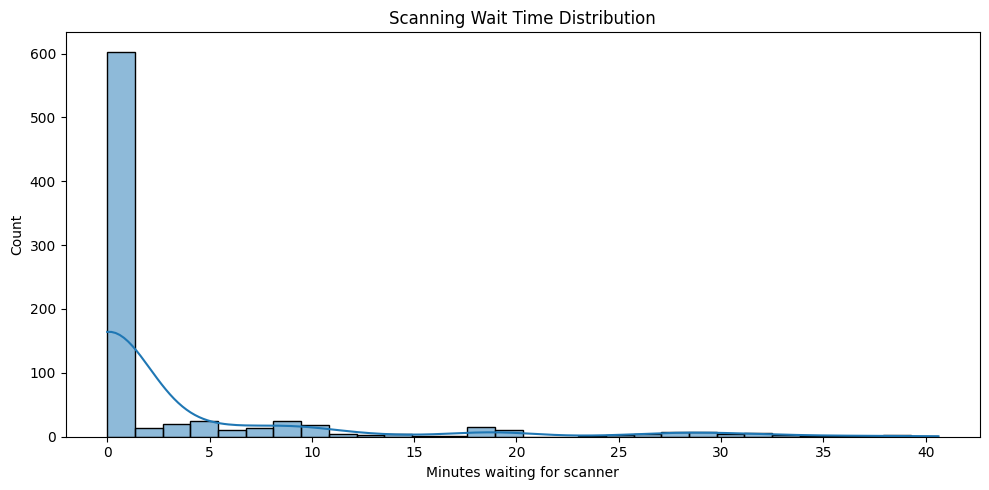

Saved: figures\run_20260107_181906\scan_wait.png


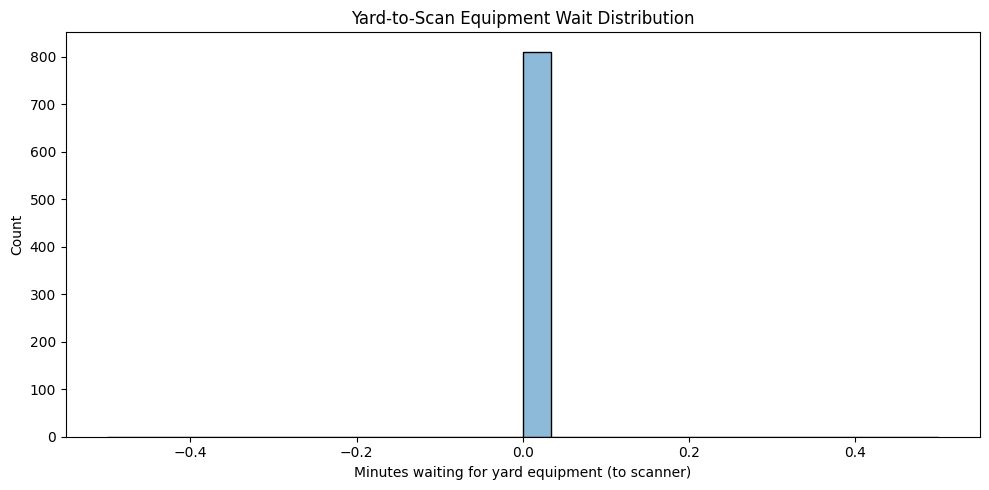

Saved: figures\run_20260107_181906\yard_to_scan_wait.png


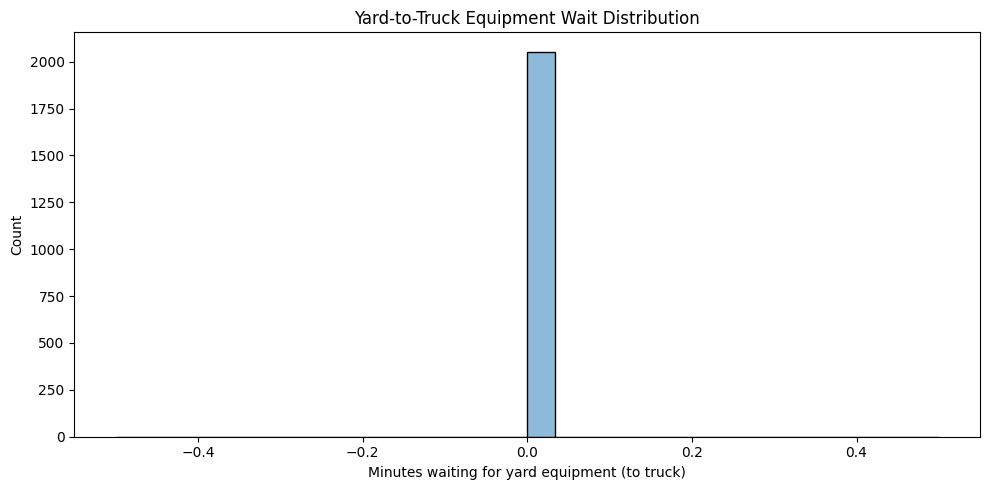

Saved: figures\run_20260107_181906\yard_to_truck_wait.png


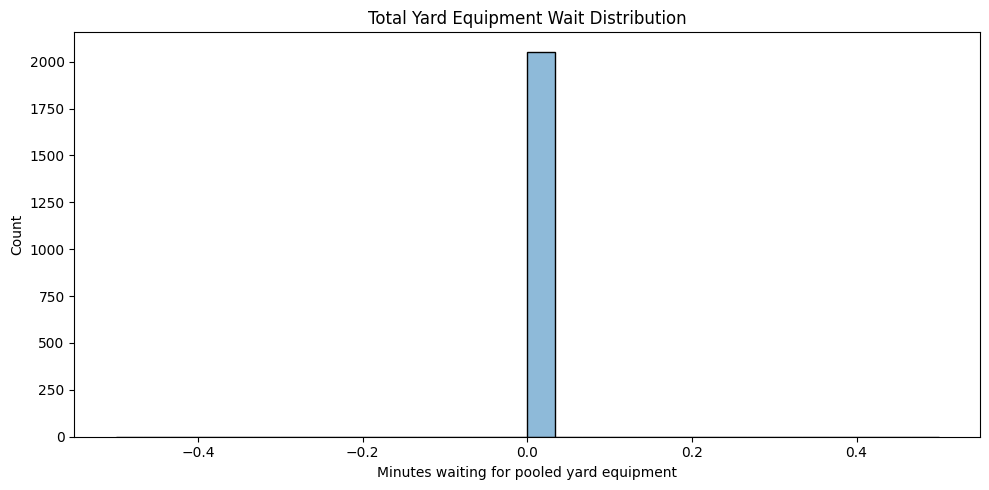

Saved: figures\run_20260107_181906\yard_equipment_wait.png


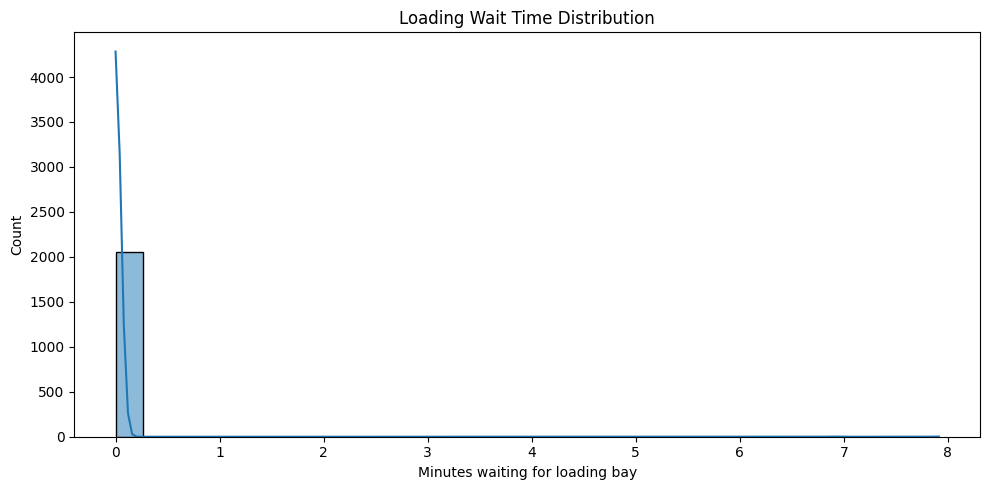

Saved: figures\run_20260107_181906\loading_wait.png


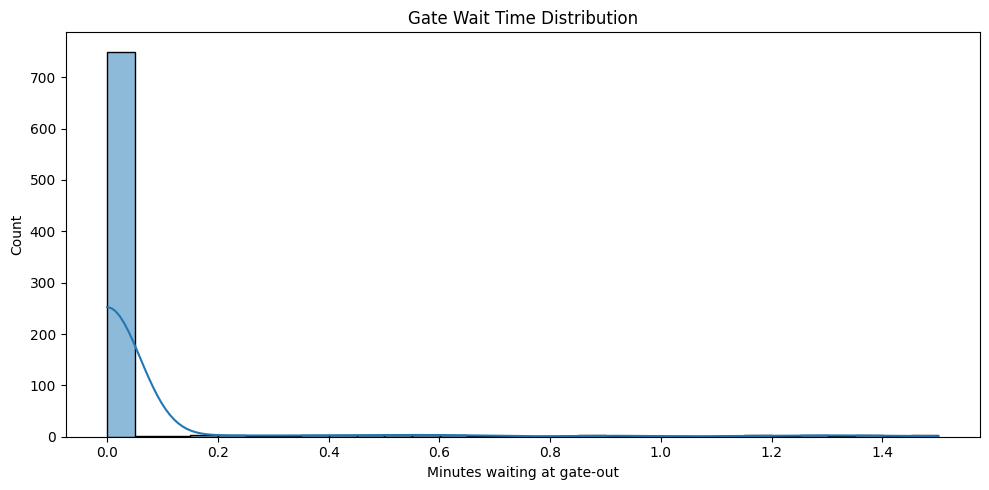

Saved: figures\run_20260107_181906\gate_wait.png


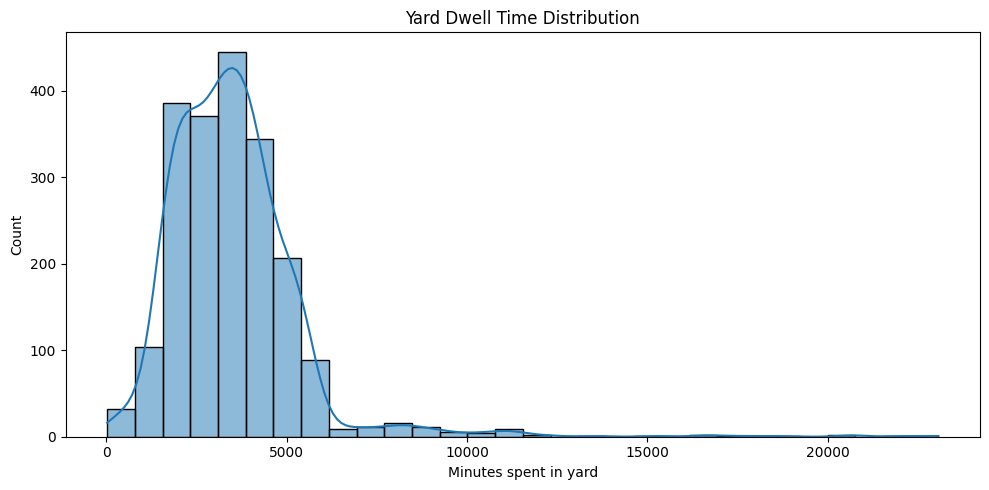

Saved: figures\run_20260107_181906\yard_dwell.png


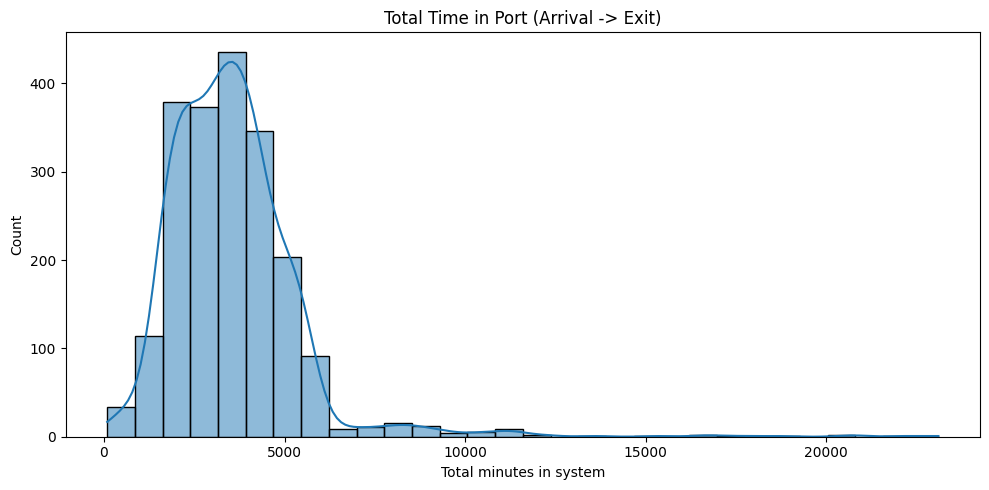

Saved: figures\run_20260107_181906\total_time.png


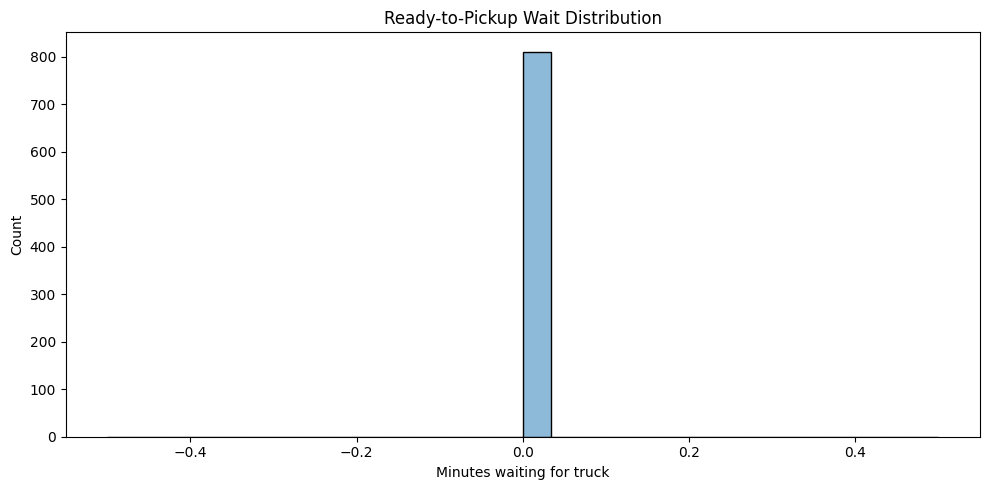

Saved: figures\run_20260107_181906\ready_to_pickup_wait.png


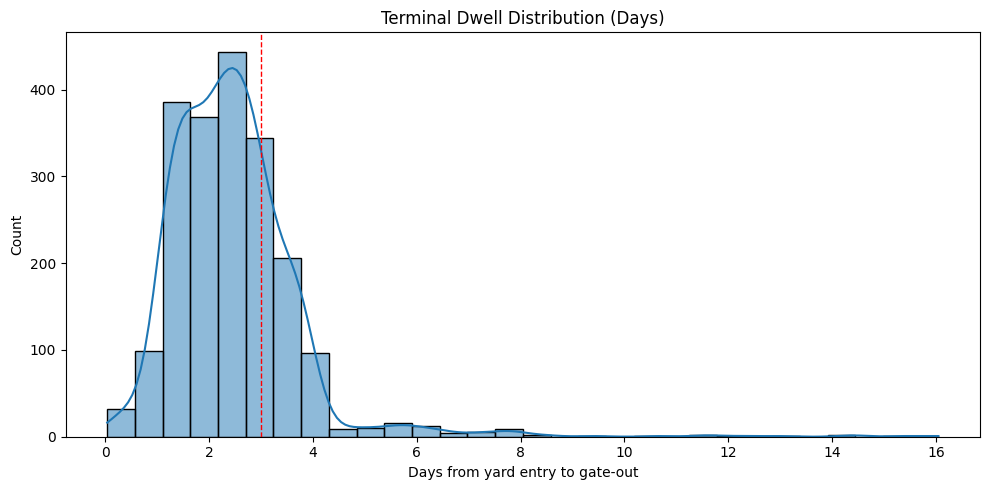

Saved: figures\run_20260107_181906\dwell_terminal_days.png


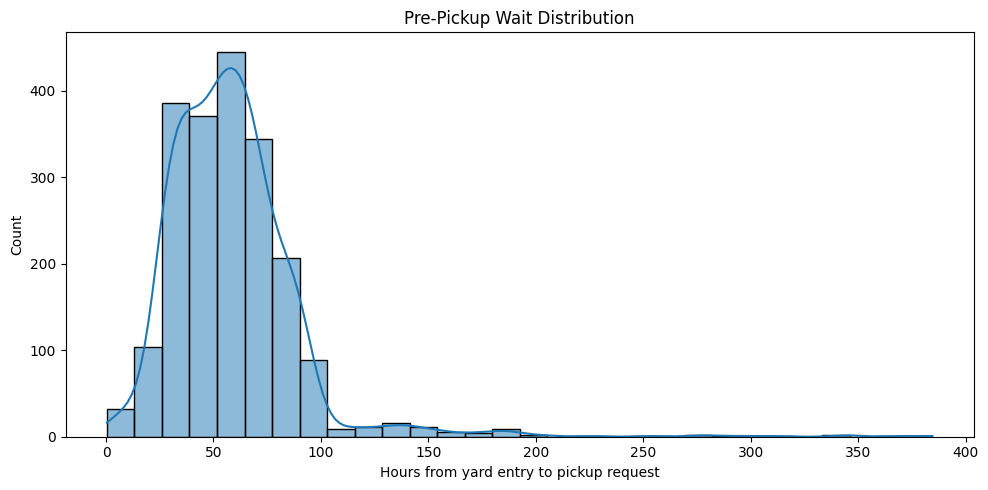

Saved: figures\run_20260107_181906\pre_pickup_wait_hours.png


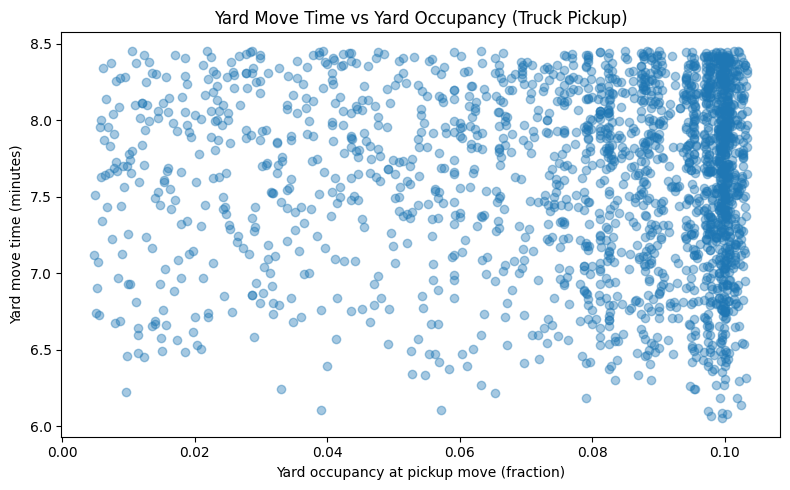

Saved: figures\run_20260107_181906\yard_move_vs_occupancy.png


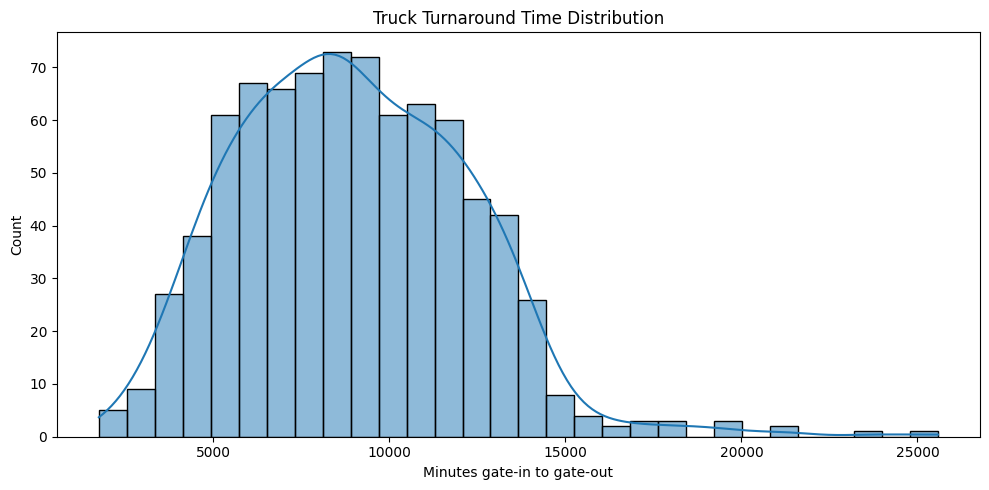

Saved: figures\run_20260107_181906\truck_turnaround.png


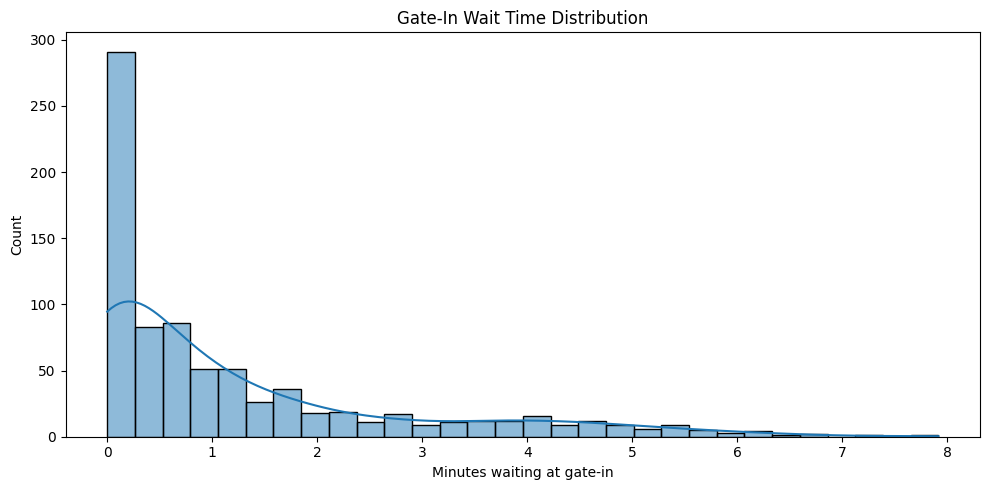

Saved: figures\run_20260107_181906\gate_in_wait.png


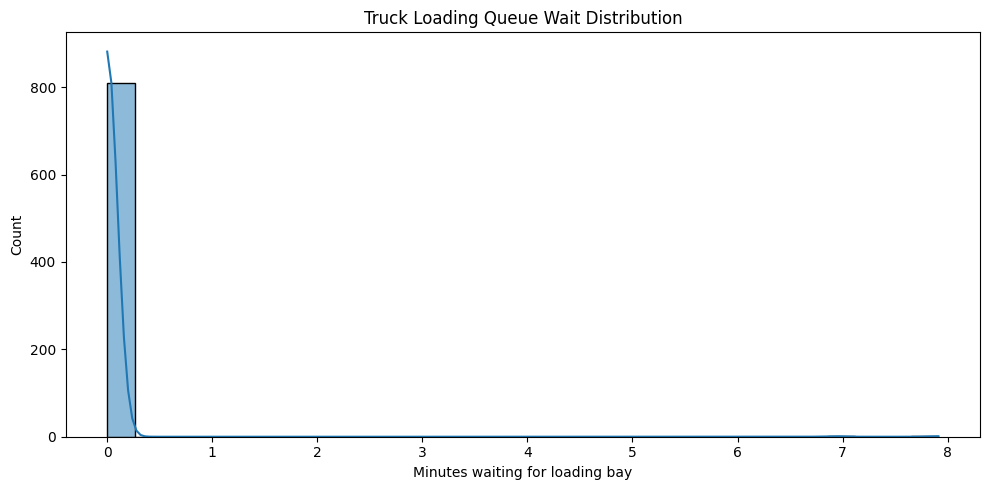

Saved: figures\run_20260107_181906\truck_loading_wait.png
No vessel metrics to plot yet.


In [10]:
# -----------------------------------------
# Plot metrics and save figures per run
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt

df = metrics_to_dataframe()
df_trucks = truck_metrics_to_dataframe()

# Skip if nothing to plot
if df.empty and df_trucks.empty:
    print("No completed containers or trucks to plot yet.")
else:
    # Create a per-run folder
    run_stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_dir = Path("figures") / f"run_{run_stamp}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    def plot_metric(data, column, title, xlabel, filename, nonnegative=False):
        if data.empty:
            print(f"Skipping {column}: dataframe empty.")
            return
        if column not in data.columns:
            print(f"Skipping {column}: column not found.")
            return
        series = data[column].dropna()
        if nonnegative:
            series = series[series >= 0]
        if series.empty:
            print(f"Skipping {column}: no non-negative values.")
            return
        plt.figure(figsize=(10, 5))
        sns.histplot(series, kde=True, bins=30)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Count")
        out = fig_dir / filename
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    # Container-level plots
    plot_metric(df, "scan_wait",
                "Scanning Wait Time Distribution",
                "Minutes waiting for scanner",
                "scan_wait.png")

    plot_metric(df, "yard_to_scan_wait",
                "Yard-to-Scan Equipment Wait Distribution",
                "Minutes waiting for yard equipment (to scanner)",
                "yard_to_scan_wait.png",
                nonnegative=True)

    plot_metric(df, "yard_to_truck_wait",
                "Yard-to-Truck Equipment Wait Distribution",
                "Minutes waiting for yard equipment (to truck)",
                "yard_to_truck_wait.png",
                nonnegative=True)

    plot_metric(df, "yard_equipment_wait",
                "Total Yard Equipment Wait Distribution",
                "Minutes waiting for pooled yard equipment",
                "yard_equipment_wait.png",
                nonnegative=True)

    plot_metric(df, "loading_wait",
                "Loading Wait Time Distribution",
                "Minutes waiting for loading bay",
                "loading_wait.png")

    plot_metric(df, "gate_wait",
                "Gate Wait Time Distribution",
                "Minutes waiting at gate-out",
                "gate_wait.png")

    plot_metric(df, "yard_dwell",
                "Yard Dwell Time Distribution",
                "Minutes spent in yard",
                "yard_dwell.png")

    plot_metric(df, "total_time",
                "Total Time in Port (Arrival -> Exit)",
                "Total minutes in system",
                "total_time.png")

    plot_metric(df, "ready_to_pickup_wait",
                "Ready-to-Pickup Wait Distribution",
                "Minutes waiting for truck",
                "ready_to_pickup_wait.png")

    # Dwell distribution in days with 72h reference line (3 days).
    if not df.empty and "dwell_terminal_days" in df.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df["dwell_terminal_days"], kde=True, bins=30)
        plt.axvline(3, color="red", linestyle="--", linewidth=1)
        # 72-hour free-time reference to show deadline clustering.
        plt.title("Terminal Dwell Distribution (Days)")
        plt.xlabel("Days from yard entry to gate-out")
        plt.ylabel("Count")
        out = fig_dir / "dwell_terminal_days.png"
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    # Pre-pickup wait distribution (hours).
    plot_metric(df, "pre_pickup_wait_hours",
                "Pre-Pickup Wait Distribution",
                "Hours from yard entry to pickup request",
                "pre_pickup_wait_hours.png")

    # Yard move time vs occupancy (optional diagnostic).
    if (not df.empty and
            "occupancy_at_yard_to_truck" in df.columns and
            "yard_to_truck_start" in df.columns and
            "yard_to_truck_end" in df.columns):
        scatter_df = df[["occupancy_at_yard_to_truck", "yard_to_truck_start", "yard_to_truck_end"]].dropna()
        if not scatter_df.empty:
            scatter_df["yard_to_truck_move_time"] = (
                scatter_df["yard_to_truck_end"] - scatter_df["yard_to_truck_start"]
            ).clip(lower=0)
            scatter_df = scatter_df[scatter_df["occupancy_at_yard_to_truck"] >= 0]
            if not scatter_df.empty:
                plt.figure(figsize=(8, 5))
                plt.scatter(
                    scatter_df["occupancy_at_yard_to_truck"],
                    scatter_df["yard_to_truck_move_time"],
                    alpha=0.4
                )
                plt.title("Yard Move Time vs Yard Occupancy (Truck Pickup)")
                plt.xlabel("Yard occupancy at pickup move (fraction)")
                plt.ylabel("Yard move time (minutes)")
                out = fig_dir / "yard_move_vs_occupancy.png"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
                plt.show()
                print(f"Saved: {out}")

    # Truck-level plots
    plot_metric(df_trucks, "ttt_total",
                "Truck Turnaround Time Distribution",
                "Minutes gate-in to gate-out",
                "truck_turnaround.png")

    plot_metric(df_trucks, "gate_in_wait",
                "Gate-In Wait Time Distribution",
                "Minutes waiting at gate-in",
                "gate_in_wait.png")

    plot_metric(df_trucks, "loading_wait",
                "Truck Loading Queue Wait Distribution",
                "Minutes waiting for loading bay",
                "truck_loading_wait.png")

    # Vessel-level plots (Phase 2)
    df_vessels = vessel_metrics_to_dataframe(VESSEL_METRICS)
    if df_vessels.empty:
        print("No vessel metrics to plot yet.")
    else:
        # Anchorage wait distribution (hours).
        if "anchorage_wait" in df_vessels.columns:
            series = df_vessels["anchorage_wait"].dropna() / 60.0
            if not series.empty:
                plt.figure(figsize=(10, 5))
                sns.histplot(series, kde=True, bins=30)
                plt.title("Anchorage Wait Distribution")
                plt.xlabel("Hours waiting at anchorage")
                plt.ylabel("Count")
                out = fig_dir / "anchorage_wait_hours.png"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
                plt.show()
                print(f"Saved: {out}")

        # Cranes assigned distribution by pier.
        if "cranes_assigned" in df_vessels.columns and "pier" in df_vessels.columns:
            plot_df = df_vessels[["cranes_assigned", "pier"]].dropna()
            if not plot_df.empty:
                plt.figure(figsize=(8, 5))
                sns.histplot(
                    data=plot_df,
                    x="cranes_assigned",
                    hue="pier",
                    multiple="dodge",
                    shrink=0.8,
                    discrete=True,
                )
                plt.title("Cranes Assigned per Vessel (by Pier)")
                plt.xlabel("Cranes assigned")
                plt.ylabel("Count")
                out = fig_dir / "cranes_assigned_by_pier.png"
                plt.tight_layout()
                plt.savefig(out, dpi=150)
                plt.show()
                print(f"Saved: {out}")

        # Berth utilization by pier (share of time occupied).
        if "berth_duration" in df_vessels.columns and "pier" in df_vessels.columns:
            util = {}
            for pier_name, cap in [("Pier 1", vp.PIER1_BERTHS), ("Pier 2", vp.PIER2_BERTHS)]:
                total = df_vessels.loc[df_vessels["pier"] == pier_name, "berth_duration"].sum()
                util[pier_name] = (total / (SIM_TIME * cap)) if SIM_TIME > 0 else 0.0
            plt.figure(figsize=(6, 4))
            plt.bar(list(util.keys()), [u * 100 for u in util.values()])
            plt.title("Berth Utilization by Pier")
            plt.ylabel("Utilization (%)")
            out = fig_dir / "berth_utilization.png"
            plt.tight_layout()
            plt.savefig(out, dpi=150)
            plt.show()
            print(f"Saved: {out}")


The wait-time distributions reveal which stages concentrate congestion, while long right tails indicate episodic delays that dominate averages.


# Baseline Seaside Productivity Diagnostics

In [11]:
minutes_per_hour = 60

crane_throughput = NUM_CRANES * (minutes_per_hour / CRANE_TIME)
scanner_throughput = NUM_SCANNERS * (minutes_per_hour / SCAN_TIME)

# Average effective loading rate from observed data
avg_loading_time = df["loading_wait"].mean() + df["loading_wait"].median()
loading_throughput = NUM_LOADING_BAYS * (minutes_per_hour / sample_loading_time())

print("Baseline Throughput Capacity (containers/hour)")
print(f"Crane throughput:    {round(crane_throughput, 1)}")
print(f"Scanner throughput:  {round(scanner_throughput, 1)}")
print(f"Loading throughput:  ~{round(loading_throughput, 1)}")

Baseline Throughput Capacity (containers/hour)
Crane throughput:    288.0
Scanner throughput:  12.0
Loading throughput:  ~43.5


# Improved Dwell Container Process

In [12]:
# -----------------------------------------
# Run Improved Dwell Simulation (Realistic)
# -----------------------------------------

# Reset metrics for improved run
METRICS_IMPROVED = []
TRUCK_METRICS_IMPROVED = []
VESSEL_METRICS_IMPROVED.clear()

# Custom record functions for improved dwell run
def record_metrics_improved(container_id, timestamps):
    METRICS_IMPROVED.append({
        "container_id": container_id,
        **timestamps
    })


def record_truck_metrics_improved(truck_id, timestamps):
    TRUCK_METRICS_IMPROVED.append({
        "truck_id": truck_id,
        **timestamps
    })


# ---------------------------------------------------
# Create environment for improved dwell simulation
# ---------------------------------------------------
env2 = simpy.Environment()

# Truck arrival profile (uses processed unit volume data)
# Keep the same calibrated loading capacity logic for comparability.
hourly_teu_rate2, truck_teu_rate_fn2 = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)

NUM_LOADING_BAYS = estimate_required_loading_bays(hourly_teu_rate2, NUM_LOADING_BAYS)
print(f"Calibrated NUM_LOADING_BAYS (improved): {NUM_LOADING_BAYS}")

# Tune rebooking thresholds to resource scale after calibration.
QUEUE_THRESHOLD_SCANNER = max(5, int(4 * NUM_SCANNERS))
QUEUE_THRESHOLD_LOADER = max(5, int(0.1 * NUM_LOADING_BAYS))
print(f"Queue thresholds (scanner/loader, improved): {QUEUE_THRESHOLD_SCANNER} / {QUEUE_THRESHOLD_LOADER}")

cranes2 = simpy.Resource(env2, capacity=NUM_CRANES)
yard2 = simpy.Container(env2, capacity=YARD_CAPACITY, init=0)
yard_equipment2 = simpy.Resource(env2, capacity=YARD_EQUIP_CAPACITY_EFFECTIVE)
scanners2 = simpy.Resource(env2, capacity=NUM_SCANNERS)
loaders2 = simpy.Resource(env2, capacity=NUM_LOADING_BAYS)
customs2 = simpy.Resource(env2, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
gate_in2 = simpy.Resource(env2, capacity=NUM_GATE_IN_LANES)
gate_out2 = simpy.Resource(env2, capacity=NUM_GATE_OUT_LANES)
ready_store2 = simpy.FilterStore(env2)
ops_token2 = simpy.Resource(env2, capacity=1)
SHIFT_STATS_IMPROVED = {"blocked_mins": 0.0}
env2.process(shift_manager(env2, ops_token2, mode="aligned", stats=SHIFT_STATS_IMPROVED))

# Start container and truck arrivals
CRANE_STATS_IMPROVED = None
if USE_VESSEL_LAYER:
    VESSEL_METRICS_IMPROVED.clear()
    berth_pier1_2, berth_pier2_2, crane_pool_pier1_2, crane_pool_pier2_2, \
    crane_stats_pier1_2, crane_stats_pier2_2 = build_quayside_resources(env2)
    CRANE_STATS_IMPROVED = {"Pier 1": crane_stats_pier1_2, "Pier 2": crane_stats_pier2_2}

    def spawn_ship_container_improved(vessel_id, idx, flow_type):
        container_label = f"V{vessel_id}_C{idx}"
        env2.process(
            container_process_post_discharge(env2, container_label, yard2, yard_equipment2, scanners2, ready_store2,
                              DWELL_PARAMS_IMP, loaders2, customs2, record_metrics_improved, flow_type,
                              ops_token=ops_token2)
        )

    env2.process(
        vessel_arrival_generator(
            env2, berth_pier1_2, berth_pier2_2,
            SIM_TIME,
            record_vessel_metrics_improved, spawn_ship_container_improved,
            crane_pool_pier1=crane_pool_pier1_2,
            crane_pool_pier2=crane_pool_pier2_2,
            crane_stats_pier1=crane_stats_pier1_2,
            crane_stats_pier2=crane_stats_pier2_2,
            flow_type_sampler=sample_ship_flow_type,
            enable_anchorage_queue=ENABLE_ANCHORAGE_QUEUE,
            include_marine_delays=INCLUDE_MARINE_DELAYS,
            moves_per_call=vp.AVG_MOVES_PER_CALL,
            teu_per_move=vp.TEU_PER_MOVE,
            interarrival_mean=vp.VESSEL_INTERARRIVAL_MEAN_MINS,
            import_share=VESSEL_IMPORT_SHARE,
        )
    )
else:
    env2.process(arrival_generator(env2, cranes2, yard2, yard_equipment2, scanners2, ready_store2, SIM_TIME,
                                  DWELL_PARAMS_IMP, loaders2, customs2, record_metrics_improved, use_flow_mix=True,
                                  ops_token=ops_token2))
env2.process(export_arrival_generator(env2, yard2, yard_equipment2, loaders2, gate_in2, SIM_TIME,
                                      record_metrics_improved, use_flow_mix=True, ops_token=ops_token2))
env2.process(
    truck_arrival_generator(
        env2, gate_in2, ready_store2, loaders2, gate_out2, yard2, yard_equipment2,
        truck_teu_rate_fn2, SIM_TIME,
        record_metrics_improved, record_truck_metrics_improved, ops_token=ops_token2
    )
)

# Run improved simulation
env2.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

print("Improved dwell simulation complete.")


C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1017997167.py:516: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)  # Create the dataframe by reading the CSV file from the provided path.


Calibrated NUM_LOADING_BAYS (improved): 23
Queue thresholds (scanner/loader, improved): 8 / 5
Improved dwell simulation complete.


# Convert improved metrics to dataframe

In [13]:
# -----------------------------------------
# Convert Improved Metrics to DataFrame
# -----------------------------------------


def metrics_to_dataframe_improved():
    return _metrics_to_dataframe(METRICS_IMPROVED)


def truck_metrics_to_dataframe_improved():
    return _truck_metrics_to_dataframe(TRUCK_METRICS_IMPROVED)


# A Peek at the Dataframe

In [14]:
df_improved = metrics_to_dataframe_improved()
df_trucks_improved = truck_metrics_to_dataframe_improved()
df_improved.head(10)


,container_id,arrival_time,flow_type,teu_size,crane_start,crane_end,yard_entry_time,pickup_request_time,scanner_queue_len_at_pickup,loader_queue_len_at_pickup,...,scan_wait,yard_to_scan_wait,yard_to_truck_wait,ready_to_pickup_wait,loading_wait,gate_wait,pre_pickup_wait,yard_equipment_wait,dwell_terminal_days,pre_pickup_wait_hours
0,S26,235.831381,TRANSSHIP,1,235.831381,239.164714,239.164714,770.618850,0.0,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,531.454137,0.0,0.396442,8.857569
1,S101,858.184216,TRANSSHIP,1,858.184216,861.517549,861.517549,1034.741607,0.0,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,173.224058,0.0,0.146976,2.887068
2,S115,978.937566,TRANSSHIP,1,978.937566,982.270899,982.270899,1135.688567,0.0,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,153.417667,0.0,0.130876,2.556961
3,S8,88.504250,TRANSSHIP,1,88.504250,91.837584,91.837584,1273.832062,0.0,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,1181.994478,0.0,0.845244,19.699908
4,S61,510.193516,TRANSSHIP,1,510.193516,513.526850,513.526850,1391.104905,0.0,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,877.578055,0.0,0.637316,14.626301
5,S159,1390.746942,TRANSSHIP,2,1390.746942,1394.080275,1394.080275,1472.037872,0.0,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,77.957596,0.0,0.078320,1.299293
6,S41,349.023653,TRANSSHIP,1,349.023653,352.356986,352.356986,1612.507006,0.0,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,1260.150020,0.0,0.901819,21.002500
7,E6,97.831607,EXPORT,1,NaN,NaN,98.633342,1729.559289,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,1630.925947,0.0,1.156386,27.182099
8,S9,92.805104,TRANSSHIP,1,92.805104,96.138438,96.138438,1725.867490,0.0,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,1629.729052,0.0,1.158645,27.162151
9,E4,72.372275,EXPORT,2,NaN,NaN,73.172730,1729.017500,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,1655.844769,0.0,1.175570,27.597413


The improved-run preview confirms the same KPI columns are present, enabling like-for-like comparison against the baseline.


In [15]:
# -----------------------------------------
# Shift Calendar Validation (Phase 4)
# -----------------------------------------

def _print_shift_validation(label, df, stats):
    blocked = stats.get("blocked_mins") if stats else None
    if blocked is None:
        print(f"{label} shift downtime blocked (mins): n/a")
    else:
        print(f"{label} shift downtime blocked (mins): {blocked:.1f}")

    print(f"{label} completed containers: {len(df)}")

    if "total_time" in df.columns and not df.empty:
        print(f"{label} mean total_time (mins): {df['total_time'].mean():.1f}")

    if SIM_TIME > 0:
        throughput_per_day = len(df) / (SIM_TIME / 1440.0)
        print(f"{label} mean throughput (containers/day): {throughput_per_day:.1f}")


_print_shift_validation("Baseline", df, globals().get("SHIFT_STATS_BASE"))
_print_shift_validation("Improved", df_improved, globals().get("SHIFT_STATS_IMPROVED"))


Baseline shift downtime blocked (mins): 3510.0
Baseline completed containers: 2054
Baseline mean total_time (mins): 3563.1
Baseline mean throughput (containers/day): 293.4
Improved shift downtime blocked (mins): 0.0
Improved completed containers: 1911
Improved mean total_time (mins): 3597.7
Improved mean throughput (containers/day): 273.0


In [16]:
# -----------------------------------------
# Vessel Layer Sanity Checks (Phase 2)
# -----------------------------------------

def _print_vessel_sanity(label, df_vessels, crane_stats=None):
    if df_vessels.empty:
        print(f"{label}: no vessel metrics (vessel mode disabled?).")
        return

    sim_weeks = SIM_TIME / (7 * 24 * 60) if SIM_TIME > 0 else 0
    vessels_per_week = len(df_vessels) / sim_weeks if sim_weeks else float('nan')

    total_containers = df_vessels.get("containers_generated", pd.Series(dtype=float)).sum()
    total_teu_generated = df_vessels.get("teu_generated", pd.Series(dtype=float)).sum()
    total_teu_full = df_vessels.get("teu_total", pd.Series(dtype=float)).sum()

    util = {}
    if "berth_duration" in df_vessels.columns and "pier" in df_vessels.columns:
        for pier_name, cap in [("Pier 1", vp.PIER1_BERTHS), ("Pier 2", vp.PIER2_BERTHS)]:
            total = df_vessels.loc[df_vessels["pier"] == pier_name, "berth_duration"].sum()
            util[pier_name] = (total / (SIM_TIME * cap)) if SIM_TIME > 0 else 0.0

    print(f"{label} vessels/week: {vessels_per_week:.1f}")
    print(f"{label} total generated containers: {total_containers:.0f}")
    print(f"{label} total generated TEU (est.): {total_teu_generated:.0f}")
    print(f"{label} total TEU (full call est.): {total_teu_full:.0f}")
    if util:
        print(f"{label} berth utilization: {util}")

    if "anchorage_wait" in df_vessels.columns:
        mean_wait = df_vessels["anchorage_wait"].dropna().mean()
        print(f"{label} mean anchorage wait (mins): {mean_wait:.1f}")

    # Effective SWH check (moves / berth-hour) vs reference lines.
    if "berth_duration" in df_vessels.columns and "moves_per_call" in df_vessels.columns:
        for pier_name in ["Pier 1", "Pier 2"]:
            subset = df_vessels[df_vessels["pier"] == pier_name].copy()
            if subset.empty:
                continue
            hours = (subset["berth_duration"] / 60.0).replace(0, pd.NA)
            swh = subset["moves_per_call"] / hours
            mean_swh = swh.dropna().mean()
            print(f"{label} mean SWH ({pier_name}): {mean_swh:.1f}")
            if mean_swh > 43:
                print(f"WARNING: {label} {pier_name} SWH above 43; efficiency too high?")
            if mean_swh < 30:
                print(f"WARNING: {label} {pier_name} SWH below 30; crane assignment too low?")

    if crane_stats:
        for pier_name, stats in crane_stats.items():
            print(
                f"{label} {pier_name} crane pool empty %: {stats.empty_ratio(SIM_TIME) * 100:.1f}"
            )

    if vp.ANNUAL_TEU_TARGET_TEU:
        annualized_teu = (total_teu_full / SIM_TIME) * (365 * 24 * 60) if SIM_TIME > 0 else 0.0
        print(f"{label} annualized TEU: {annualized_teu:.0f} vs target {vp.ANNUAL_TEU_TARGET_TEU}")
    else:
        print(f"{label} annual TEU target: not set (fill vp.ANNUAL_TEU_TARGET_TEU)")


df_vessels_base = vessel_metrics_to_dataframe_base()
df_vessels_improved = vessel_metrics_to_dataframe_improved()
_print_vessel_sanity("Baseline", df_vessels_base, CRANE_STATS_BASE)
_print_vessel_sanity("Improved", df_vessels_improved, CRANE_STATS_IMPROVED)


Baseline: no vessel metrics (vessel mode disabled?).
Improved: no vessel metrics (vessel mode disabled?).


In [17]:
print_validation_summary("Improved", df_improved, df_trucks_improved)


Improved - Validation Summary
Truck turnaround (min) mean/median/p90: 9010.9 / 8789.9 / 12990.8
gate_in_wait mean (min): 0.9
loading_wait mean (min): 0.0
gate_out_wait mean (min): 0.0
ready_to_pickup_wait mean (min): 0.0
Note: These are student case-study calibration targets; not official operations.


In [18]:
def quality_checks(label, df):
    # Basic sanity checks to confirm non-empty data and no negative waits.
    print(f"{label} rows: {len(df)}")
    if df.empty:
        return

    if "flow_type" in df.columns:
        counts = df["flow_type"].value_counts()
        print(f"{label} flow_type counts:\n{counts.to_string()}")

    wait_cols = [
        "scan_wait",
        "yard_to_scan_wait",
        "yard_to_truck_wait",
        "yard_equipment_wait",
        "loading_wait",
        "gate_wait",
        "pre_pickup_wait",
        "ready_to_pickup_wait",
        "customs_queue_wait",
        "customs_inspection_time",
        "customs_hold_delay",
        "rebook_delay",
    ]
    for col in wait_cols:
        if col in df.columns:
            print(f"{label} min {col}: {df[col].min():.2f}")

    negative_cols = [
        col for col in wait_cols
        if col in df.columns and (df[col] < 0).any()
    ]
    if negative_cols:
        joined = ", ".join(negative_cols)
        print(f"{label} negative waits detected in: {joined}")

    if "pre_pickup_wait_hours" in df.columns:
        p50 = df["pre_pickup_wait_hours"].quantile(0.5)
        p90 = df["pre_pickup_wait_hours"].quantile(0.9)
        p99 = df["pre_pickup_wait_hours"].quantile(0.99)
        share_deadline = ((df["pre_pickup_wait_hours"] >= 60) & (df["pre_pickup_wait_hours"] <= 72)).mean()
        print(f"{label} pre_pickup_wait_hours p50/p90/p99: {p50:.1f} / {p90:.1f} / {p99:.1f}")
        print(f"{label} share in 60-72h window: {share_deadline:.2%}")

        target_deadline = DEADLINE_GROUP_PROB_BASE if label == "Baseline" else DEADLINE_GROUP_PROB_IMP
        if abs(share_deadline - target_deadline) > 0.05:
            print(f"{label} note: adjust DEADLINE_GROUP_PROB_* (target {target_deadline:.0%})")

    if "dwell_terminal_days" in df.columns:
        p50 = df["dwell_terminal_days"].quantile(0.5)
        p90 = df["dwell_terminal_days"].quantile(0.9)
        p99 = df["dwell_terminal_days"].quantile(0.99)
        print(f"{label} dwell_terminal_days p50/p90/p99: {p50:.1f} / {p90:.1f} / {p99:.1f}")

    # Summary for yard equipment wait and total time (required for verification).
    for col in ["yard_equipment_wait", "total_time"]:
        if col in df.columns:
            mean = df[col].mean()
            p50 = df[col].quantile(0.5)
            p90 = df[col].quantile(0.9)
            print(f"{label} {col} mean/p50/p90: {mean:.1f} / {p50:.1f} / {p90:.1f}")

    # Rates for calibration checks.
    if "customs_hold_delay" in df.columns:
        hold_rate = (df["customs_hold_delay"] > 0).mean()
        print(f"{label} customs hold rate: {hold_rate:.2%}")
        target_hold = CUSTOMS_HOLD_PROB_BASE if label == "Baseline" else CUSTOMS_HOLD_PROB_IMP
        if abs(hold_rate - target_hold) > 0.02:
            print(f"{label} note: adjust CUSTOMS_HOLD_PROB_* (target {target_hold:.0%})")
    if "rebook_delay" in df.columns:
        rebook_rate = (df["rebook_delay"] > 0).mean()
        print(f"{label} rebook rate: {rebook_rate:.2%}")

    # Queue length diagnostics for rebooking thresholds.
    if "scanner_queue_len_at_pickup" in df.columns:
        p90 = df["scanner_queue_len_at_pickup"].quantile(0.9)
        print(f"{label} scanner_queue_len_at_pickup p90: {p90:.0f}")
        if p90 < (QUEUE_THRESHOLD_SCANNER * 0.5):
            print(f"{label} note: consider lowering QUEUE_THRESHOLD_SCANNER")
        if p90 > QUEUE_THRESHOLD_SCANNER:
            print(f"{label} note: consider raising QUEUE_THRESHOLD_SCANNER")

    if "loader_queue_len_at_pickup" in df.columns:
        p90 = df["loader_queue_len_at_pickup"].quantile(0.9)
        print(f"{label} loader_queue_len_at_pickup p90: {p90:.0f}")
        if p90 < (QUEUE_THRESHOLD_LOADER * 0.5):
            print(f"{label} note: consider lowering QUEUE_THRESHOLD_LOADER")
        if p90 > QUEUE_THRESHOLD_LOADER:
            print(f"{label} note: consider raising QUEUE_THRESHOLD_LOADER")


quality_checks("Baseline", df)
quality_checks("Improved", df_improved)


Baseline rows: 2054
Baseline flow_type counts:
flow_type
EXPORT       838
IMPORT       811
TRANSSHIP    405
Baseline min scan_wait: 0.00
Baseline min yard_to_scan_wait: 0.00
Baseline min yard_to_truck_wait: 0.00
Baseline min yard_equipment_wait: 0.00
Baseline min loading_wait: 0.00
Baseline min gate_wait: 0.00
Baseline min pre_pickup_wait: 24.97
Baseline min ready_to_pickup_wait: 0.00
Baseline pre_pickup_wait_hours p50/p90/p99: 55.4 / 87.1 / 178.3
Baseline share in 60-72h window: 19.62%
Baseline note: adjust DEADLINE_GROUP_PROB_* (target 50%)
Baseline dwell_terminal_days p50/p90/p99: 2.3 / 3.7 / 7.5
Baseline yard_equipment_wait mean/p50/p90: 0.0 / 0.0 / 0.0
Baseline total_time mean/p50/p90: 3563.1 / 3385.7 / 5316.4
Baseline scanner_queue_len_at_pickup p90: 0
Baseline note: consider lowering QUEUE_THRESHOLD_SCANNER
Baseline loader_queue_len_at_pickup p90: 0
Baseline note: consider lowering QUEUE_THRESHOLD_LOADER
Improved rows: 1911
Improved flow_type counts:
flow_type
EXPORT       786
I

# Side-by-Side Comparison Plots

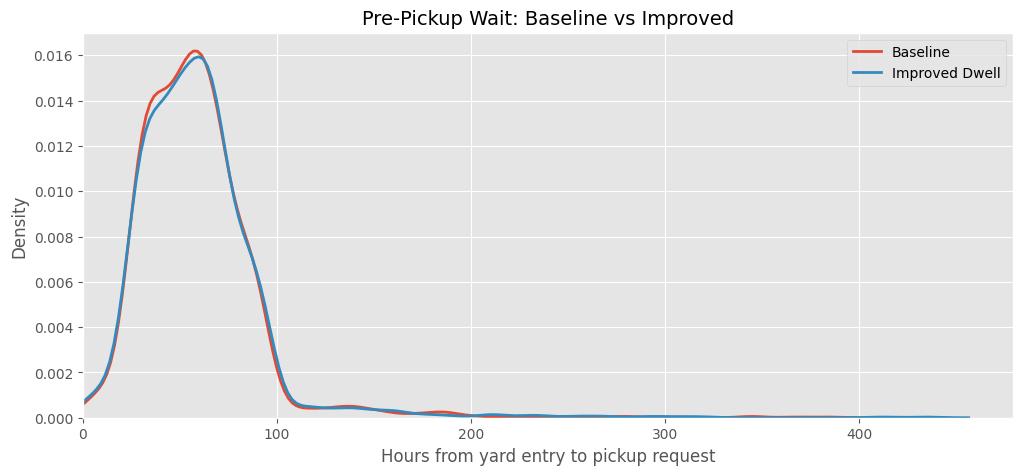

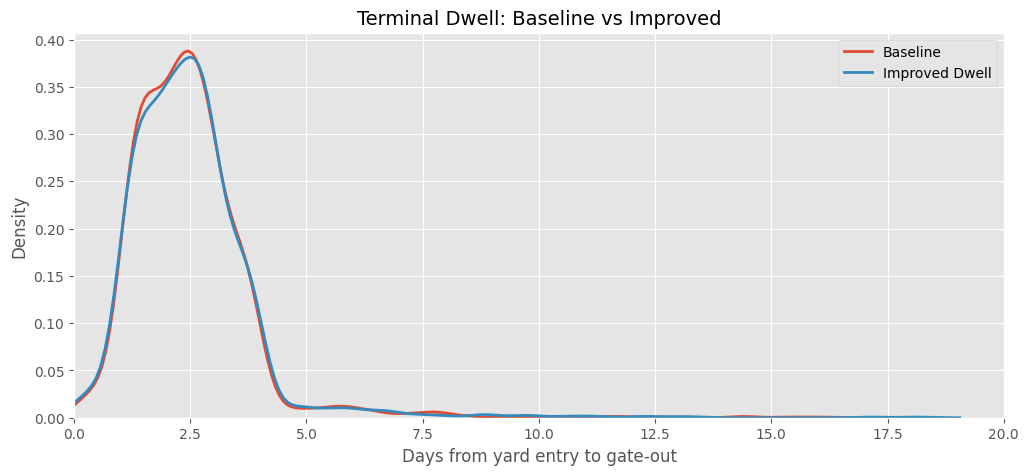

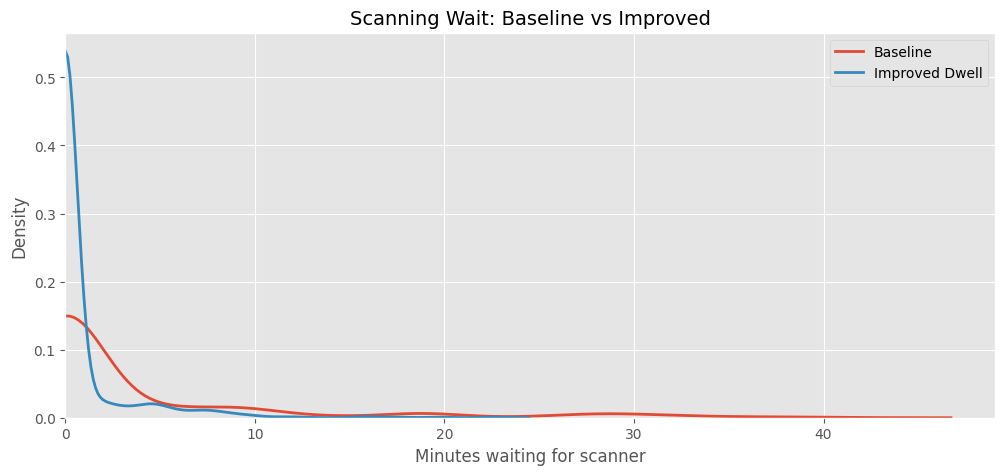

C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


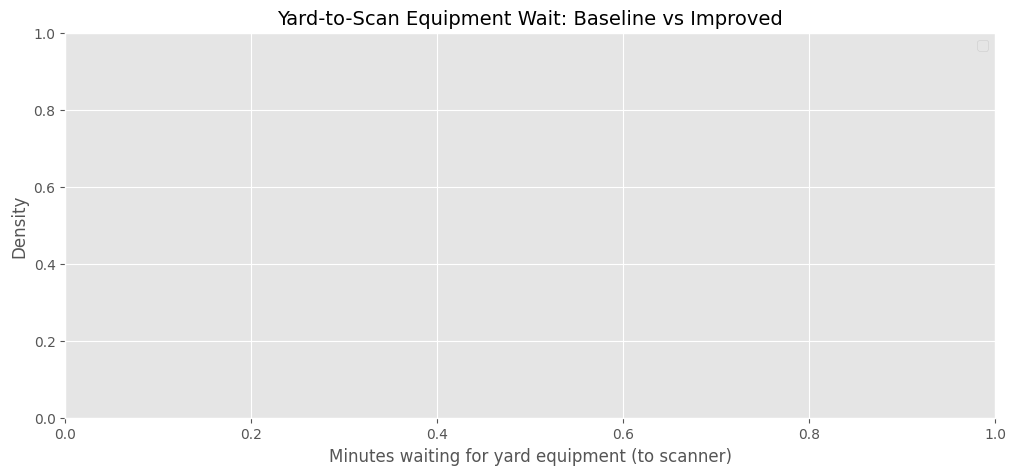

C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


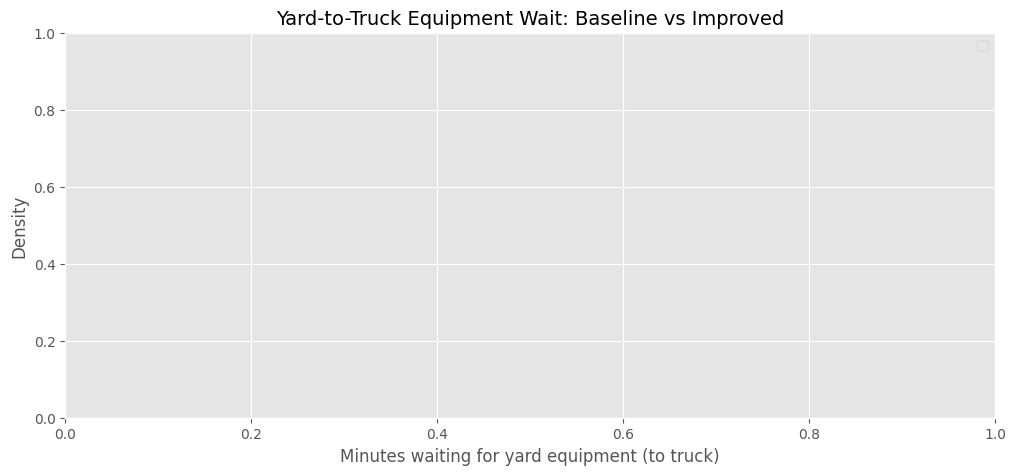

C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))
C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


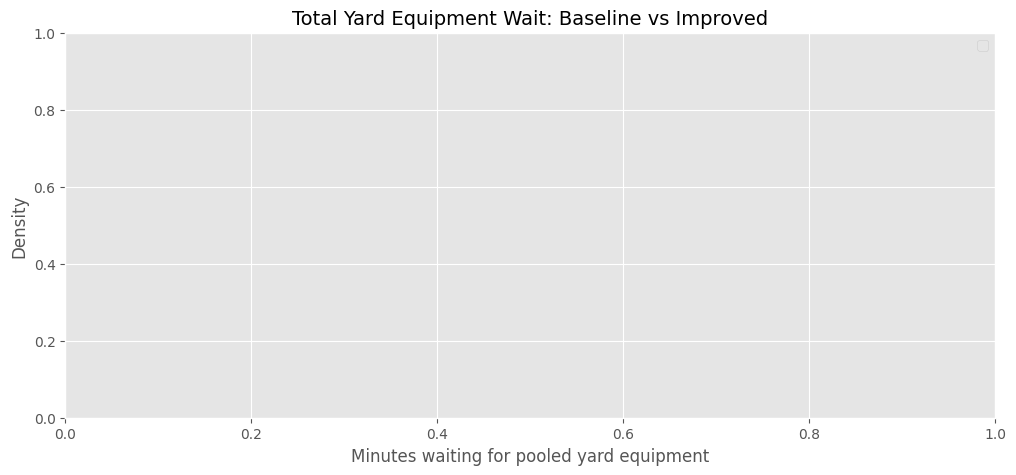

C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1034886577.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))


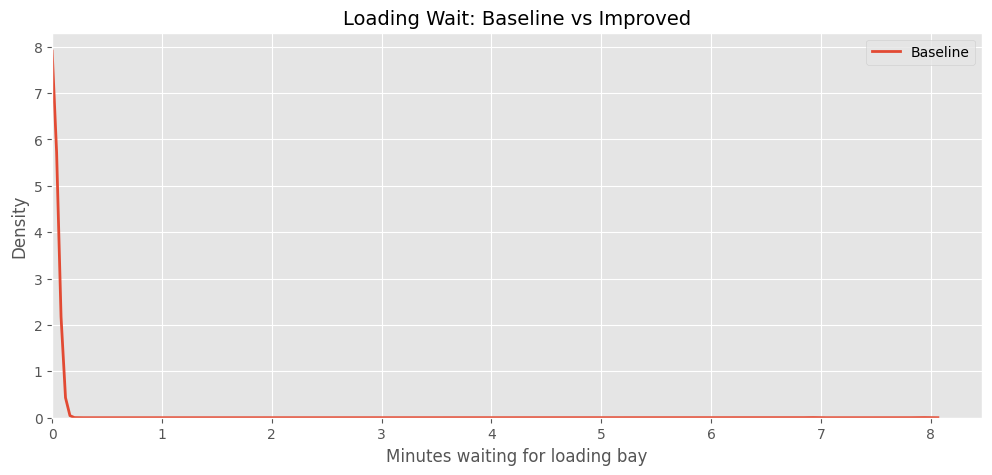

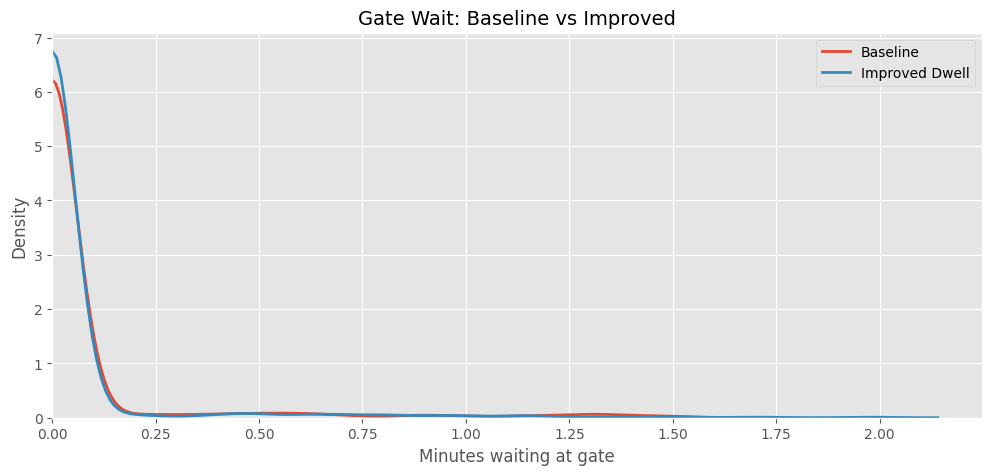

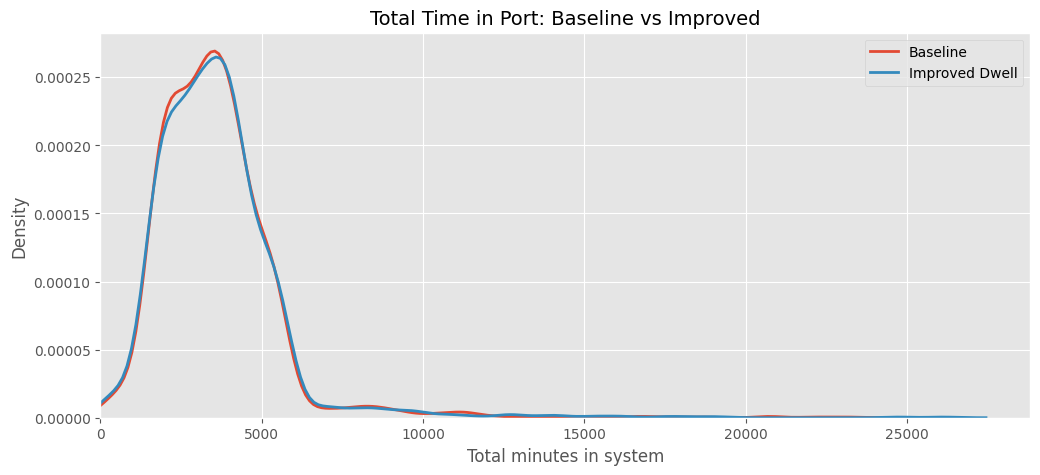

In [19]:
# -----------------------------------------
# Compare Baseline vs Improved Dwell
# -----------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

def compare_distributions(df1, df2, column, title, xlabel):
    if column not in df1.columns or column not in df2.columns:
        print(f"Skipping {column}: missing in dataframe.")
        return

    plt.figure(figsize=(12,5))

    # Clip KDE to non-negative domain (the correct domain for waits)
    sns.kdeplot(df1[column], label="Baseline", linewidth=2, clip=(0, None))
    sns.kdeplot(df2[column], label="Improved Dwell", linewidth=2, clip=(0, None))

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.xlim(left=0)   # Force the X-axis to start at 0
    plt.legend()
    plt.show()


# ------- Required comparisons -------

compare_distributions(df, df_improved,
                      "pre_pickup_wait_hours",
                      "Pre-Pickup Wait: Baseline vs Improved",
                      "Hours from yard entry to pickup request")

compare_distributions(df, df_improved,
                      "dwell_terminal_days",
                      "Terminal Dwell: Baseline vs Improved",
                      "Days from yard entry to gate-out")

compare_distributions(df, df_improved,
                      "scan_wait",
                      "Scanning Wait: Baseline vs Improved",
                      "Minutes waiting for scanner")

compare_distributions(df, df_improved,
                      "yard_to_scan_wait",
                      "Yard-to-Scan Equipment Wait: Baseline vs Improved",
                      "Minutes waiting for yard equipment (to scanner)")

compare_distributions(df, df_improved,
                      "yard_to_truck_wait",
                      "Yard-to-Truck Equipment Wait: Baseline vs Improved",
                      "Minutes waiting for yard equipment (to truck)")

compare_distributions(df, df_improved,
                      "yard_equipment_wait",
                      "Total Yard Equipment Wait: Baseline vs Improved",
                      "Minutes waiting for pooled yard equipment")

compare_distributions(df, df_improved,
                      "loading_wait",
                      "Loading Wait: Baseline vs Improved",
                      "Minutes waiting for loading bay")

compare_distributions(df, df_improved,
                      "gate_wait",
                      "Gate Wait: Baseline vs Improved",
                      "Minutes waiting at gate")

compare_distributions(df, df_improved,
                      "total_time",
                      "Total Time in Port: Baseline vs Improved",
                      "Total minutes in system")


The improved curves should generally shift left relative to baseline, indicating shorter waits and lower system time under the policy changes.


### **Comparison: Baseline vs Improved Yard Dwell**

These plots compare the baseline simulation and the improved-dwell simulation.

The goal is to show how reducing yard dwell time affects:

- overall throughput  
- queue lengths  
- system congestion  
- end-to-end transit time  



#### **1. Yard Dwell**
This should show a significant left-shift (shorter dwell times).

#### **2. Scanning Wait**
Reduced yard congestion allows containers to reach scanning earlier.

#### **3. Loading Wait**
Lower yard occupancy improves container accessibility for loading.

#### **4. Gate Wait**
Gate-out is fast, but improvements upstream reduce peaks.

#### **5. Total Time in System**
This is the most important KPI —  
a large reduction here validates operational impact.

These will form the graphs used in the report and presentation.


# Compute Numerical Improvements

In [20]:
# -----------------------------------------
# Numerical Performance Improvements
# -----------------------------------------

def percentage_change(before, after):
    """Percent reduction; handles zero to avoid divide-by-zero warnings."""
    # Normalize to plain floats to avoid np.float64 in output.
    before = float(before)
    after = float(after)
    if before == 0:
        if after == 0:
            return 0.0
        return float('nan')
    return float(round(((before - after) / before) * 100, 2))

results = {}

# Mean values
results["Mean Total Time Reduction (%)"] = percentage_change(
    df["total_time"].mean(),
    df_improved["total_time"].mean()
)

results["Mean Yard Dwell Reduction (%)"] = percentage_change(
    df["yard_dwell"].mean(),
    df_improved["yard_dwell"].mean()
)

results["Mean Scanning Wait Reduction (%)"] = percentage_change(
    df["scan_wait"].mean(),
    df_improved["scan_wait"].mean()
)

results["Mean Loading Wait Reduction (%)"] = percentage_change(
    df["loading_wait"].mean(),
    df_improved["loading_wait"].mean()
)

results["Mean Gate Wait Reduction (%)"] = percentage_change(
    df["gate_wait"].mean(),
    df_improved["gate_wait"].mean()
)

results


{'Mean Total Time Reduction (%)': -0.97,
 'Mean Yard Dwell Reduction (%)': -1.3,
 'Mean Scanning Wait Reduction (%)': 77.58,
 'Mean Loading Wait Reduction (%)': 100.0,
 'Mean Gate Wait Reduction (%)': 17.42}

Positive percentage reductions here quantify the operational benefit of the improved scenario, with larger values indicating the most responsive bottlenecks.


### **Numerical Performance Improvements**

This table quantifies how much performance improves under the reduced dwell policy.

We measure:

- average total time in the port  
- average yard dwell time  
- average scanning wait  
- average loading wait  
- average gate wait  

Each is expressed as a **percentage reduction** relative to baseline.

This forms the core of your optimisation results for the report.


## Yard Equipment Stress Test (Crisis Capacity)

This stress run uses the SOURCE-ANCHORED crisis capacity range to test yard-equipment bottlenecks.


In [21]:
# -----------------------------------------
# Yard Equipment Stress Test (Crisis Capacity)
# -----------------------------------------

# SOURCE-ANCHORED range; midpoint used as a stress-test assumption.
crisis_capacity_mid = int(round(sum(YARD_EQUIP_CAPACITY_CRISIS_RANGE) / 2))
print(f"Crisis yard equipment capacity (midpoint): {crisis_capacity_mid}")

# Local metrics for stress run to avoid mixing with baseline/improved.
METRICS_STRESS = []
TRUCK_METRICS_STRESS = []

def record_metrics_stress(container_id, timestamps):
    """Append one container metrics row for the stress run."""
    METRICS_STRESS.append({"container_id": container_id, **timestamps})


def record_truck_metrics_stress(truck_id, timestamps):
    """Append one truck metrics row for the stress run."""
    TRUCK_METRICS_STRESS.append({"truck_id": truck_id, **timestamps})

env_stress = simpy.Environment()

# Use the same truck arrival profile for comparability.
hourly_teu_rate_stress, truck_teu_rate_fn_stress = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)

num_loading_bays_stress = estimate_required_loading_bays(hourly_teu_rate_stress, NUM_LOADING_BAYS)
print(f"Calibrated NUM_LOADING_BAYS (stress): {num_loading_bays_stress}")

# Align rebooking thresholds with the stress-run loader capacity.
prev_scanner_threshold = QUEUE_THRESHOLD_SCANNER
prev_loader_threshold = QUEUE_THRESHOLD_LOADER
QUEUE_THRESHOLD_SCANNER = max(5, int(4 * NUM_SCANNERS))
QUEUE_THRESHOLD_LOADER = max(5, int(0.1 * num_loading_bays_stress))
print(f"Queue thresholds (stress): {QUEUE_THRESHOLD_SCANNER} / {QUEUE_THRESHOLD_LOADER}")

# Resources for the stress run.
cranes_s = simpy.Resource(env_stress, capacity=NUM_CRANES)
yard_s = simpy.Container(env_stress, capacity=YARD_CAPACITY, init=0)
yard_equipment_s = simpy.Resource(env_stress, capacity=crisis_capacity_mid)
scanners_s = simpy.Resource(env_stress, capacity=NUM_SCANNERS)
loaders_s = simpy.Resource(env_stress, capacity=num_loading_bays_stress)
customs_s = simpy.Resource(env_stress, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
gate_in_s = simpy.Resource(env_stress, capacity=NUM_GATE_IN_LANES)
gate_out_s = simpy.Resource(env_stress, capacity=NUM_GATE_OUT_LANES)
ready_store_s = simpy.FilterStore(env_stress)

env_stress.process(
    arrival_generator(env_stress, cranes_s, yard_s, yard_equipment_s, scanners_s, ready_store_s,
                      SIM_TIME, DWELL_PARAMS_BASE, loaders_s, customs_s, record_metrics_stress)
)
env_stress.process(
    truck_arrival_generator(
        env_stress, gate_in_s, ready_store_s, loaders_s, gate_out_s, yard_s, yard_equipment_s,
        truck_teu_rate_fn_stress, SIM_TIME,
        record_metrics_stress, record_truck_metrics_stress
    )
)

env_stress.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

# Restore thresholds after stress run to avoid side effects.
QUEUE_THRESHOLD_SCANNER = prev_scanner_threshold
QUEUE_THRESHOLD_LOADER = prev_loader_threshold

df_stress = _metrics_to_dataframe(METRICS_STRESS)
if df_stress.empty:
    print("Stress run produced no completed containers.")
else:
    if "yard_equipment_wait" in df_stress.columns:
        s = df_stress["yard_equipment_wait"].dropna()
        print(
            "Stress yard_equipment_wait mean/p50/p90: "
            f"{s.mean():.1f} / {s.quantile(0.5):.1f} / {s.quantile(0.9):.1f}"
        )
    if "total_time" in df_stress.columns:
        t = df_stress["total_time"].dropna()
        print(
            "Stress total_time mean/p50/p90: "
            f"{t.mean():.1f} / {t.quantile(0.5):.1f} / {t.quantile(0.9):.1f}"
        )


Crisis yard equipment capacity (midpoint): 52


C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1017997167.py:516: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)  # Create the dataframe by reading the CSV file from the provided path.


Calibrated NUM_LOADING_BAYS (stress): 23
Queue thresholds (stress): 8 / 5
Stress yard_equipment_wait mean/p50/p90: 0.0 / 0.0 / 0.0
Stress total_time mean/p50/p90: 4143.3 / 3975.0 / 5675.6


## Yard Equipment Sensitivity (Availability Sweep)

Availability is varied to expose bottlenecks; arrival rates are held constant for comparability.


In [22]:
# -----------------------------------------
# Yard Equipment Sensitivity (Availability Sweep)
# -----------------------------------------

# ASSUMPTION TO TUNE: shorter run to keep sensitivity scans fast.
SENSITIVITY_SIM_DAYS = 1
SENSITIVITY_SIM_TIME = SENSITIVITY_SIM_DAYS * 24 * 60

# ASSUMPTION TO TUNE: scale arrivals to expose yard-equipment bottlenecks.
ARRIVAL_RATE_MULTIPLIER_SENS = 10
SENS_CONTAINER_INTERARRIVAL_MEAN = 5 / ARRIVAL_RATE_MULTIPLIER_SENS

# ASSUMPTION TO TUNE: availability targets for sensitivity.
AVAIL_TARGETS = [0.20, 0.30, 0.40, 0.59]

# Keep the same arrival profile for each availability level.
hourly_teu_rate_sens, truck_teu_rate_fn_sens = load_teu_arrival_profile(
    path=TRUCK_ARRIVAL_DATA_PATH,
    facility_code=TRUCK_ARRIVAL_FACILITY,
    category_filter=TRUCK_ARRIVAL_CATEGORY,
    report_month=TRUCK_ARRIVAL_REPORT_MONTH,
)
hourly_teu_rate_sens_scaled = [rate * ARRIVAL_RATE_MULTIPLIER_SENS for rate in hourly_teu_rate_sens]
num_loading_bays_sens = estimate_required_loading_bays(hourly_teu_rate_sens_scaled, NUM_LOADING_BAYS)

def truck_teu_rate_fn_sens_scaled(t_min):
    """Scale truck arrival rates for sensitivity stress testing."""
    return truck_teu_rate_fn_sens(t_min) * ARRIVAL_RATE_MULTIPLIER_SENS

sensitivity_rows = []

for avail in AVAIL_TARGETS:
    capacity_effective = max(1, round(YARD_EQUIP_CAPACITY_NOMINAL * avail))

    # Local metrics for this availability level.
    metrics_level = []
    truck_metrics_level = []

    def record_metrics_level(container_id, timestamps):
        """Append one container metrics row for the sensitivity run."""
        metrics_level.append({"container_id": container_id, **timestamps})

    def record_truck_metrics_level(truck_id, timestamps):
        """Append one truck metrics row for the sensitivity run."""
        truck_metrics_level.append({"truck_id": truck_id, **timestamps})

    env_sens = simpy.Environment()

    # Align rebooking thresholds with the sensitivity loader capacity.
    prev_scanner_threshold = QUEUE_THRESHOLD_SCANNER
    prev_loader_threshold = QUEUE_THRESHOLD_LOADER
    QUEUE_THRESHOLD_SCANNER = max(5, int(4 * NUM_SCANNERS))
    QUEUE_THRESHOLD_LOADER = max(5, int(0.1 * num_loading_bays_sens))

    cranes_s = simpy.Resource(env_sens, capacity=NUM_CRANES)
    yard_s = simpy.Container(env_sens, capacity=YARD_CAPACITY, init=0)
    yard_equipment_s = simpy.Resource(env_sens, capacity=capacity_effective)
    scanners_s = simpy.Resource(env_sens, capacity=NUM_SCANNERS)
    loaders_s = simpy.Resource(env_sens, capacity=num_loading_bays_sens)
    customs_s = simpy.Resource(env_sens, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
    gate_in_s = simpy.Resource(env_sens, capacity=NUM_GATE_IN_LANES)
    gate_out_s = simpy.Resource(env_sens, capacity=NUM_GATE_OUT_LANES)
    ready_store_s = simpy.FilterStore(env_sens)

    env_sens.process(
        arrival_generator(env_sens, cranes_s, yard_s, yard_equipment_s, scanners_s, ready_store_s,
                          SENSITIVITY_SIM_TIME, DWELL_PARAMS_BASE, loaders_s, customs_s, record_metrics_level,
                          interarrival_mean=SENS_CONTAINER_INTERARRIVAL_MEAN)
    )
    env_sens.process(
        truck_arrival_generator(
            env_sens, gate_in_s, ready_store_s, loaders_s, gate_out_s, yard_s, yard_equipment_s,
            truck_teu_rate_fn_sens_scaled, SENSITIVITY_SIM_TIME,
            record_metrics_level, record_truck_metrics_level
        )
    )

    env_sens.run(until=SENSITIVITY_SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)

    # Restore thresholds after this run.
    QUEUE_THRESHOLD_SCANNER = prev_scanner_threshold
    QUEUE_THRESHOLD_LOADER = prev_loader_threshold

    df_level = _metrics_to_dataframe(metrics_level)
    if df_level.empty:
        print(f"No completed containers for availability {avail:.2f}")
        continue

    yard_wait = df_level["yard_equipment_wait"].dropna() if "yard_equipment_wait" in df_level.columns else pd.Series(dtype=float)
    total_time = df_level["total_time"].dropna() if "total_time" in df_level.columns else pd.Series(dtype=float)

    sensitivity_rows.append({
        "avail_target": avail,
        "capacity_effective": capacity_effective,
        "yard_equipment_wait_mean": yard_wait.mean() if not yard_wait.empty else float('nan'),
        "yard_equipment_wait_p90": yard_wait.quantile(0.9) if not yard_wait.empty else float('nan'),
        "total_time_mean": total_time.mean() if not total_time.empty else float('nan'),
        "total_time_p90": total_time.quantile(0.9) if not total_time.empty else float('nan'),
    })

df_sensitivity = pd.DataFrame(sensitivity_rows)
if df_sensitivity.empty:
    print("Sensitivity sweep produced no results.")
else:
    print(df_sensitivity)


C:\Users\nkany\AppData\Local\Temp\ipykernel_432\1017997167.py:516: DtypeWarning: Columns (13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)  # Create the dataframe by reading the CSV file from the provided path.


   avail_target  capacity_effective  yard_equipment_wait_mean  \
0          0.20                  22                       0.0   
1          0.30                  33                       0.0   
2          0.40                  44                       0.0   
3          0.59                  64                       0.0   

   yard_equipment_wait_p90  total_time_mean  total_time_p90  
0                      0.0      5207.770377     9289.241700  
1                      0.0      5104.747082     9166.584323  
2                      0.0      4993.735227     8941.994340  
3                      0.0      5158.783893     9111.108687  


As availability targets decline, rising mean/p90 waits signal nonlinear congestion effects and highlight where capacity is most constrained.


## Truck + TAS Simulation (Phase 2)

How to run:
1. Run the parameter cell at the top to set TAS assumptions and multipliers.
2. Run the TAS simulation cell below to generate containers and TAS-scheduled trucks.
3. Run the TAS plots cell to view staging wait and turnaround distributions.


In [23]:
# -----------------------------------------
# Truck + TAS Simulation (Phase 2)
# -----------------------------------------

# Reset TAS metrics to avoid mixing with baseline/improved.
reset_tas_metrics()

env3 = simpy.Environment()

# Build TAS parameters from Phase 2 assumptions.
tas_params = TruckTASParams(
    trucks_per_day=TRUCKS_PER_DAY_PIER2_BASE,
    hourly_arrival_multipliers=HOURLY_ARRIVAL_MULTIPLIERS,
    slot_minutes=TAS_SLOT_MINUTES,
    late_tolerance_mins=TAS_LATE_TOLERANCE_MINS,
    no_show_prob=NO_SHOW_PROB,
    rebook_delay_mean_mins=REBOOK_DELAY_MEAN_MINS,
    rebook_delay_sigma_mins=REBOOK_DELAY_SIGMA_MINS,
    arrival_std_mins=ARRIVAL_STD_MINS,
)

# Calibrate loading bays from TAS truck volume (assumes 2 TEU per truck).
hourly_trucks = [(tas_params.trucks_per_day / 24.0) * m for m in tas_params.hourly_arrival_multipliers]
hourly_teu_rate_tas = [h * TRUCK_CAPACITY_TEU for h in hourly_trucks]
num_loading_bays_tas = estimate_required_loading_bays(hourly_teu_rate_tas, NUM_LOADING_BAYS)
print(f"Calibrated NUM_LOADING_BAYS (TAS): {num_loading_bays_tas}")

# Define resources for the TAS run.
cranes3 = simpy.Resource(env3, capacity=NUM_CRANES)
yard3 = simpy.Container(env3, capacity=YARD_CAPACITY, init=0)
yard_equipment3 = simpy.Resource(env3, capacity=YARD_EQUIP_CAPACITY_EFFECTIVE)
scanners3 = simpy.Resource(env3, capacity=NUM_SCANNERS)
loaders3 = simpy.Resource(env3, capacity=num_loading_bays_tas)
customs3 = simpy.Resource(env3, capacity=NUM_CUSTOMS_INSPECTION_BAYS)
gate_in3 = simpy.Resource(env3, capacity=GATE_LANES_PIER2)
gate_out3 = simpy.Resource(env3, capacity=GATE_LANES_PIER2)
ready_store3 = simpy.FilterStore(env3)

# Container arrivals feed ready containers; keep baseline dwell behavior for comparability.
env3.process(
    arrival_generator(env3, cranes3, yard3, yard_equipment3, scanners3, ready_store3, SIM_TIME,
                      DWELL_PARAMS_BASE, loaders3, customs3, record_metrics_tas)
)

# TAS truck arrivals are independent and claim ready containers on arrival.
env3.process(
    truck_tas_arrival_generator(
        env3,
        tas_params,
        ready_store3,
        gate_in3,
        loaders3,
        gate_out3,
        yard3,
        SIM_TIME,
        record_truck_metrics_tas,
        select_containers_fn=select_containers_for_truck,
        gate_in_time_fn=sample_gate_in_time,
        gate_out_time_fn=sample_gate_out_time,
        pickup_service_time_fn=sample_loading_time,
        record_container_metrics=record_metrics_tas,
    )
)

try:
    env3.run(until=SIM_TIME + MAX_DWELL + POST_PROCESS_BUFFER)
    print("Truck + TAS simulation complete.")
except ValueError as exc:
    print(f"Truck + TAS simulation skipped: {exc}")


Calibrated NUM_LOADING_BAYS (TAS): 60
Truck + TAS simulation complete.


TAS - TTT_terminal (min) mean/median/p90: 9102.4 / 8926.3 / 13202.6


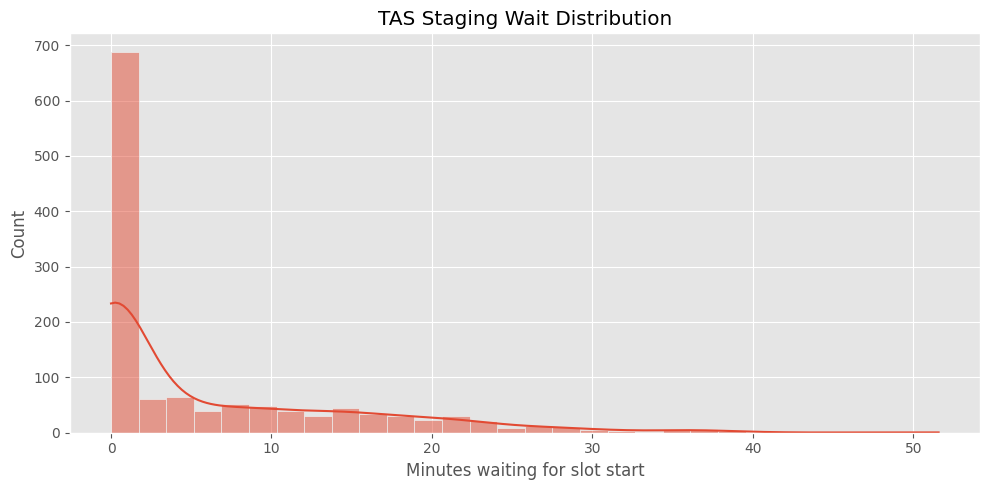

Saved: figures\run_20260107_182110\tas_staging_wait.png


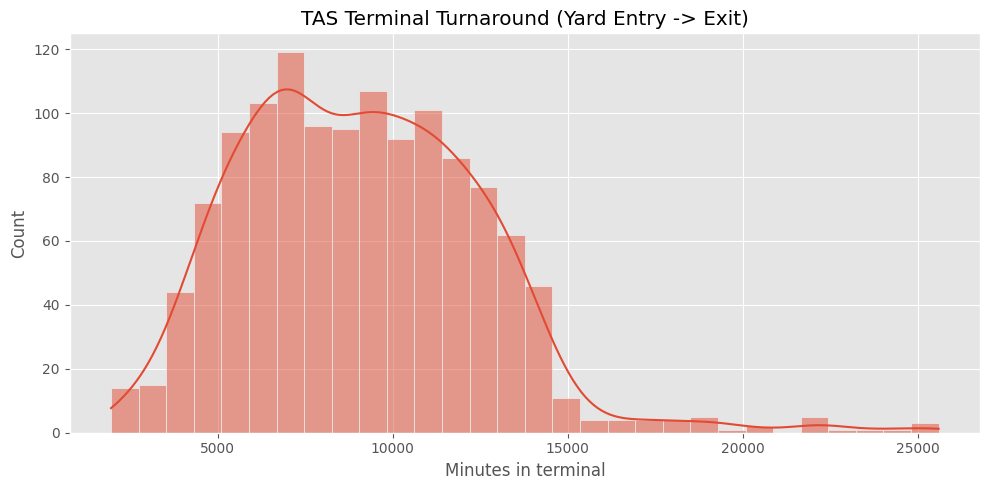

Saved: figures\run_20260107_182110\tas_ttt_terminal.png


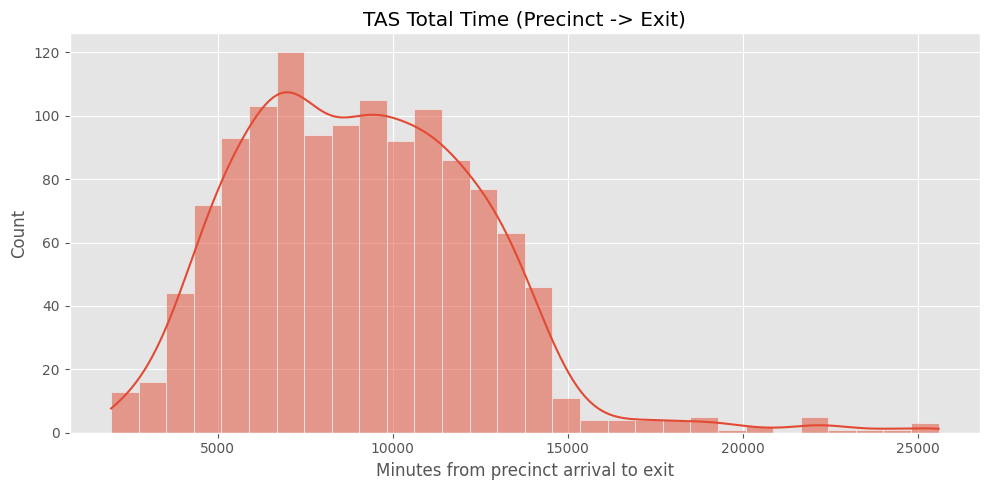

Saved: figures\run_20260107_182110\tas_total_time.png


In [24]:
# -----------------------------------------
# TAS Plots + Summary
# -----------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime as dt

df_trucks_tas = tas_truck_metrics_to_dataframe(TRUCK_METRICS_TAS)

if df_trucks_tas.empty:
    print("No TAS truck metrics to plot yet.")
else:
    if "TTT_terminal" in df_trucks_tas.columns:
        ttt = df_trucks_tas["TTT_terminal"].dropna()
        if not ttt.empty:
            print(
                "TAS - TTT_terminal (min) mean/median/p90: "
                f"{ttt.mean():.1f} / {ttt.median():.1f} / {ttt.quantile(0.9):.1f}"
            )
        else:
            print("TTT_terminal is empty; check TAS metrics.")
    else:
        print("TTT_terminal column missing; check TAS metrics.")

    run_stamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    fig_dir = Path("figures") / f"run_{run_stamp}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    def plot_tas_metric(data, column, title, xlabel, filename):
        if column not in data.columns:
            print(f"Skipping {column}: column not found.")
            return
        plt.figure(figsize=(10, 5))
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel("Count")
        out = fig_dir / filename
        plt.tight_layout()
        plt.savefig(out, dpi=150)
        plt.show()
        print(f"Saved: {out}")

    plot_tas_metric(
        df_trucks_tas,
        "staging_wait",
        "TAS Staging Wait Distribution",
        "Minutes waiting for slot start",
        "tas_staging_wait.png",
    )

    plot_tas_metric(
        df_trucks_tas,
        "TTT_terminal",
        "TAS Terminal Turnaround (Yard Entry -> Exit)",
        "Minutes in terminal",
        "tas_ttt_terminal.png",
    )

    plot_tas_metric(
        df_trucks_tas,
        "total_time",
        "TAS Total Time (Precinct -> Exit)",
        "Minutes from precinct arrival to exit",
        "tas_total_time.png",
    )


The TAS distributions show how appointment adherence reshapes staging and terminal turnaround, with tighter spreads indicating better gate discipline.


# 9. Discussion & Interpretation
Across the comparisons, focus on which stages dominate total time and how policy shifts alter queue tails rather than only means.
Use the sensitivity and TAS results to identify where operational slack is most valuable for stabilizing turnaround.


# 10. Limitations

Current limitations (summary):
- The CLI demo uses synthetic arrivals and scaled timings; it is not a calibrated operational model.
- The CLI demo excludes vessel/berth and TAS logic (notebook-only).
- Customs hold and rebooking logic are defined in helpers but are not wired into the main flow.
- Vessel-layer parameters previously tied to a missing source file are treated as assumptions.
- Notebook runs are non-deterministic unless a seed is set manually.
- Full notebook runs can be heavy due to large CSV loads and long horizons.

See `docs/limitations.md` for the full list.


# 11. Next Steps
Immediate next steps focus on data integration and calibration to tighten scenario realism.


Next Integration Step (when unit volume data is clean)
- Expected CSV schema: date, hour, facility_code, teu_total (or teus)
- Ensure facility_code includes DCT so load_teu_arrival_profile can filter.
- Plug the cleaned CSV path into load_teu_arrival_profile(path=..., facility_code="DCT").


NOTE: The following project change notes are retained for provenance and do not alter the editorial structure above.


NOTE: This change list is retained for provenance; see the Editorial Change Log at the end for structural edits.

What changed & why
- Replaced fixed 3/5/7 day dwell with an integrated MVIA-style process (free-time behavior, customs holds, rebooking).
- Added an inspection resource to approximate customs queues instead of pure delay.
- Tuned queue thresholds and loading capacity assumptions to better align with operational scale.
- Added new timestamps and KPIs (pre_pickup_wait, customs_hold_delay, rebook_delay, dwell_terminal).
- Added dwell and pre-pickup plots with a 72-hour reference line for KPI interpretation.
- Added a Truck + TAS (Phase 2) section with NHPP arrivals, slot validation, and staging wait logic.
- Added TAS-specific metrics and plots (staging wait, terminal TTT, total time).
- Added pooled yard equipment constraints for yard-to-scan and yard-to-truck moves with congestion-sensitive move times.
- Added yard equipment stress and availability sensitivity runs to expose bottleneck behavior.
- Added flow_type split with separate ship vs truck entry sources (IMPORT/EXPORT/TRANSSHIP).
- Added vessel/berth + crane assignment (gang intensity) with discharge-driven arrivals and vessel plots.


NOTE: This log captures prior research updates; the Editorial Change Log at the end covers this editorial pass.

### **Change Log**
- **Research Update:** Updated all parameter assumptions with credible sources (Transnet, World Bank, Industry Reports).
- **Scope Definition:** Added clear In/Out of Scope section.
- **Experiment Design:** Explicitly defined Baseline vs Improved scenarios.
- **Validation:** Added validation criteria for queue formation and throughput.


# Editorial Change Log
- Added a title-and-abstract front matter and a manual Table of Contents to frame the chapter flow.
- Inserted numbered section headings (1-11) and short transition text to align narrative order with code blocks.
- Reordered markdown cells to group overview, assumptions, logic, experiments, metrics, and results without moving code cells.
- Added interpretation paragraphs immediately after plot/table outputs.
- Moved the existing "Next Integration Step" content into the Next Steps section and appended provenance notes for legacy change logs.
